<a href="https://colab.research.google.com/github/Sumalyo/MONN_work/blob/main/MONN_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

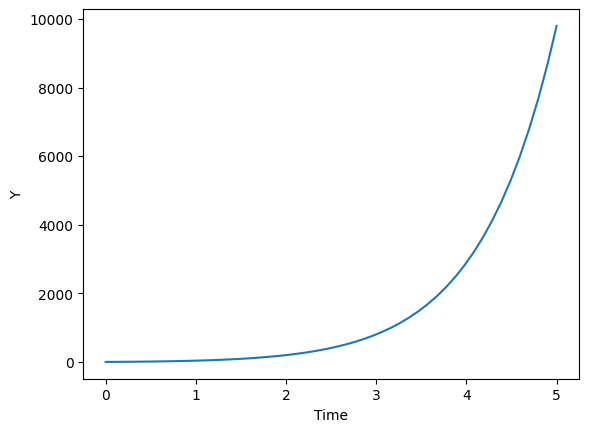

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial condition
y0 = 1

# Time points
t = np.linspace(0, 5)

# Define the differential equation using lambda
# dy/dt = -y * t + 13
dydt = lambda y, t: 13 * np.exp(t) + y

# Solve the ODE
y = odeint(dydt, y0, t)

plt.plot(t, y)
plt.xlabel("Time")
plt.ylabel("Y")
plt.show()

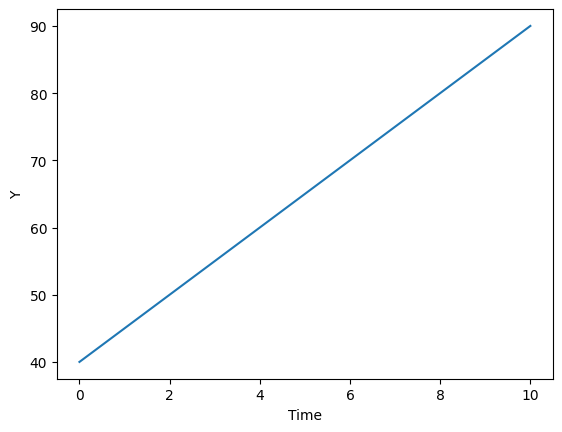

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial condition
y0 = 40

# Time points
t = np.linspace(0, 10,1000)

# Define the differential equation using lambda
# dy/dt = -y * t + 13
dydt = lambda y, t: 5

# Solve the ODE
y = odeint(dydt, y0, t)

plt.plot(t, y)
plt.xlabel("Time")
plt.ylabel("Y")
plt.show()

Starting simulation for 0.5 seconds...
Simulation finished. Plotting results.


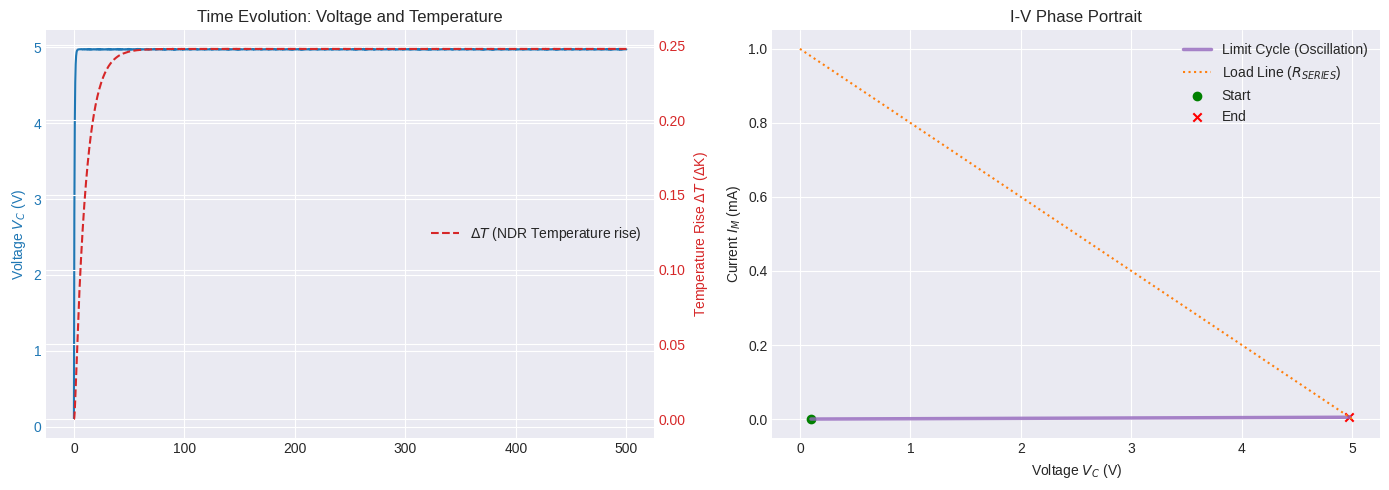


--- Simulation Summary ---
Final V_C range: 0.100 V to 4.981 V
Final T range: 300.0 K to 300.2 K (Delta T: 0.2 K)
NDR device must have an S-type characteristic for these parameters to oscillate.


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Circuit and Model Parameters ---

# Circuit parameters (External components)
V_BIAS = 5.0    # DC Supply Voltage (Volts)
R_SERIES = 5e3  # Series Load Resistor (Ohms). Must be large enough to enable NDR operation.
C_CAP = 100e-9  # External Capacitor (Farads). Provides the slow voltage dynamics.

# Thermal NDR Model Parameters (Device parameters)
T_AMB = 300.0   # Ambient Temperature (Kelvin)
C_TH = 1e-6     # Thermal Capacitance (J/K)
G_TH = 1e-4     # Thermal Conductance to ambient (W/K) (1/R_th)

# Electrical Conductance Parameters
# This model uses an Arrhenius-like temperature dependence for conductance,
# which is common for oxide-based threshold switches.
G_0 = 1e-6      # Low-temp (leakage) conductance (Siemens)
G_1 = 0.5e-3    # Factor for high-temp conductance (Siemens)
E_A = 0.4       # Activation Energy (eV) - determines sensitivity to temp
K_B = 8.617e-5  # Boltzmann Constant (eV/K)

# --- 2. Defining the System of ODEs (The Derivatives) ---

def electro_thermal_ndr_ode(t, Y):
    """
    Defines the system of two coupled ordinary differential equations (ODEs).

    The state vector Y = [V_C, T], where:
    V_C: Voltage across the capacitor (and NDR device)
    T: Temperature of the active region of the NDR device

    dY/dt = [dV_C/dt, dT/dt]

    Args:
        t (float): Time (s)
        Y (np.array): State vector [V_C, T] at time t

    Returns:
        np.array: The time derivative vector [dV_C/dt, dT_dt]
    """
    V_C, T = Y

    # --- Step 1: Calculate the NDR device's dynamic conductance G(T) ---
    # G(T) = G_0 + G_1 * exp(-E_A / (K_B * T))
    # Note: The exponential term causes the conductance to increase rapidly
    # when T increases, which is the source of the thermal positive feedback.
    try:
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    except OverflowError:
        # Handle potential overflow if T gets extremely low (shouldn't happen here)
        G_M = G_0

    # --- Step 2: Calculate Current and Power ---
    I_M = G_M * V_C  # Current through the NDR device
    P_M = I_M * V_C  # Power dissipated by Joule heating

    # --- Step 3: Calculate the Derivatives ---

    # 1. dV_C/dt (Electrical Circuit Equation - KCL)
    # C * dV_C/dt = (V_BIAS - V_C) / R_SERIES - I_M
    I_R = (V_BIAS - V_C) / R_SERIES
    dV_C_dt = (I_R - I_M) / C_CAP

    # 2. dT/dt (Thermal Equation - Energy Balance)
    # C_th * dT/dt = P_M - G_TH * (T - T_AMB)
    P_diss = G_TH * (T - T_AMB)
    dT_dt = (P_M - P_diss) / C_TH

    return np.array([dV_C_dt, dT_dt])

# --- 3. Simulation Setup and Execution ---

# Initial conditions (V_C and T)
# Start near a stable point, but slightly perturbed, or low voltage.
Y0 = np.array([0.1, T_AMB])

# Time span for the simulation
T_SPAN = [0, 0.5] # 0 to 0.5 seconds
T_POINTS = np.linspace(T_SPAN[0], T_SPAN[1], 5000)

print(f"Starting simulation for {T_SPAN[1]} seconds...")

# Solve the ODE system
solution = solve_ivp(
    electro_thermal_ndr_ode,
    T_SPAN,
    Y0,
    t_eval=T_POINTS,
    method='RK45', # Runge-Kutta method for accuracy
    atol=1e-6,
    rtol=1e-3
)
# solution = odeint(
#     electro_thermal_ndr_ode,
#     T_SPAN,
#     Y0,
#     t_eval=T_POINTS,
#     method='RK45', # Runge-Kutta method for accuracy
#     atol=1e-6,
#     rtol=1e-3
# )

print("Simulation finished. Plotting results.")

# Extract results
V_C_sim = solution.y[0]
T_sim = solution.y[1]
t_sim = solution.t

# Calculate I_M and NDR I-V characteristic (for plotting the characteristic curve)
I_M_sim = np.zeros_like(V_C_sim)
for i in range(len(V_C_sim)):
    T = T_sim[i]
    G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    I_M_sim[i] = G_M * V_C_sim[i]

# --- 4. Plotting Results ---

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 5))

# --- Plot 1: Voltage and Temperature vs. Time ---
plt.subplot(1, 2, 1)
plt.plot(t_sim * 1000, V_C_sim, label='$V_C$ (Voltage across NDR)', color='tab:blue')
plt.ylabel('Voltage $V_C$ (V)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

# Create a second axis for temperature
ax2 = plt.gca().twinx()
# FIX: Use raw string (r'...') to prevent Python from interpreting \D as an escape sequence
ax2.plot(t_sim * 1000, T_sim - T_AMB, label=r'$\Delta T$ (NDR Temperature rise)', color='tab:red', linestyle='--')
# FIX: Use raw string (r'...') to prevent Python from interpreting \D as an escape sequence
ax2.set_ylabel(r'Temperature Rise $\Delta T$ ($\Delta$K)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Time Evolution: Voltage and Temperature')
plt.xlabel('Time (ms)')
plt.legend(loc='center right')


# --- Plot 2: NDR I-V Characteristic (Phase Portrait) ---
plt.subplot(1, 2, 2)
# Calculate the load line (I_R vs. V_C at the equilibrium points)
# I_R = (V_BIAS - V_C) / R_SERIES
V_C_load = np.linspace(0, V_BIAS, 100)
I_R_load = (V_BIAS - V_C_load) / R_SERIES

plt.plot(V_C_sim, I_M_sim * 1000, label='Limit Cycle (Oscillation)', color='tab:purple', linewidth=2.5, alpha=0.8)
plt.plot(V_C_load, I_R_load * 1000, label=r'Load Line ($R_{SERIES}$)', color='tab:orange', linestyle=':')
plt.scatter(V_C_sim[0], I_M_sim[0] * 1000, color='green', marker='o', label='Start')
plt.scatter(V_C_sim[-1], I_M_sim[-1] * 1000, color='red', marker='x', label='End')

plt.title('I-V Phase Portrait')
plt.xlabel('Voltage $V_C$ (V)')
plt.ylabel('Current $I_M$ (mA)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Final Oscillation Info ---
print("\n--- Simulation Summary ---")
print(f"Final V_C range: {np.min(V_C_sim):.3f} V to {np.max(V_C_sim):.3f} V")
print(f"Final T range: {np.min(T_sim):.1f} K to {np.max(T_sim):.1f} K (Delta T: {np.max(T_sim) - T_AMB:.1f} K)")
print(f"NDR device must have an S-type characteristic for these parameters to oscillate.")

<>:141: SyntaxWarning: invalid escape sequence '\D'
<>:156: SyntaxWarning: invalid escape sequence '\_'
<>:141: SyntaxWarning: invalid escape sequence '\D'
<>:156: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipython-input-501764062.py:141: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Time Evolution: $V_C$ and $\Delta T$ (Solver Comparison)')
/tmp/ipython-input-501764062.py:156: SyntaxWarning: invalid escape sequence '\_'
  plt.plot(V_C_ivp, I_M_ivp * 1000, label='Limit Cycle (solve\_ivp)', color='tab:purple', linewidth=2.5, alpha=0.8)


Starting simulation for 0.5 seconds...
solve_ivp simulation finished.

Starting simulation using odeint...
odeint simulation finished. Plotting results.


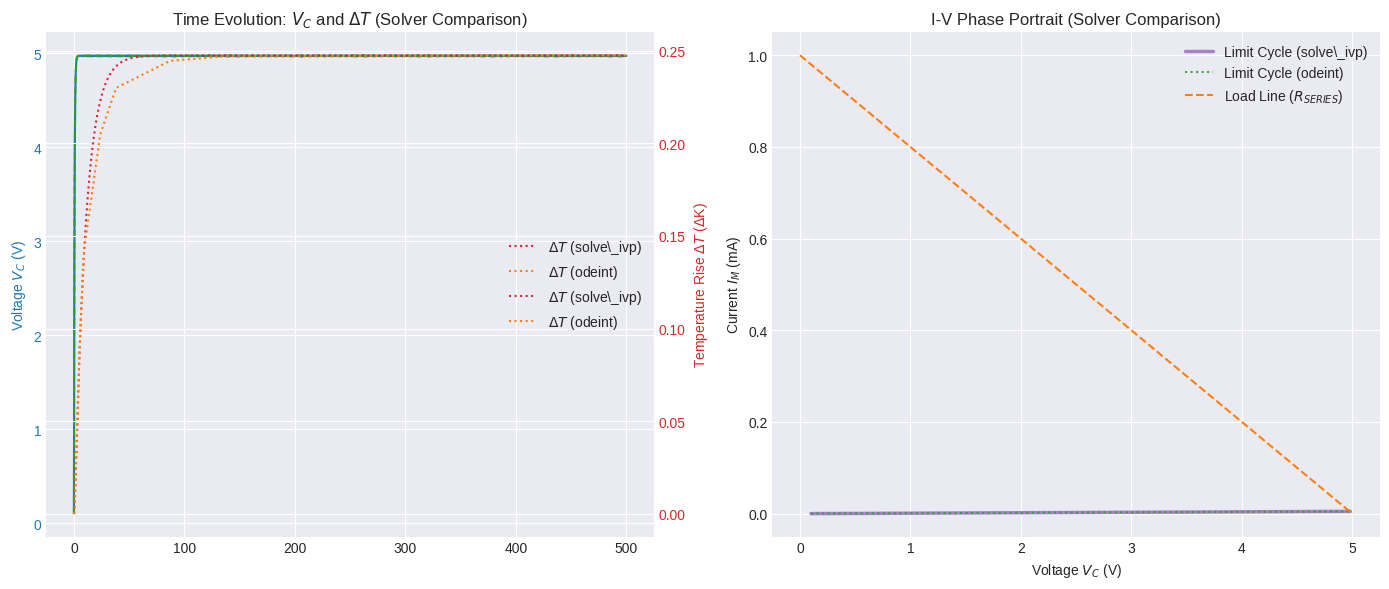


--- Simulation Summary ---
Solver Comparison (Min/Max V_C):
solve_ivp: 0.100 V to 4.981 V
odeint:    0.100 V to 4.975 V

Solver Comparison (Min/Max T):
solve_ivp: 300.0 K to 300.2 K
odeint:    300.0 K to 300.2 K

NDR device must have an S-type characteristic for these parameters to oscillate.


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp, odeint # Added odeint
import matplotlib.pyplot as plt

# --- 1. Circuit and Model Parameters ---

# Circuit parameters (External components)
V_BIAS = 5.0    # DC Supply Voltage (Volts)
R_SERIES = 5e3  # Series Load Resistor (Ohms). Must be large enough to enable NDR operation.
C_CAP = 100e-9  # External Capacitor (Farads). Provides the slow voltage dynamics.

# Thermal NDR Model Parameters (Device parameters)
T_AMB = 300.0   # Ambient Temperature (Kelvin)
C_TH = 1e-6     # Thermal Capacitance (J/K)
G_TH = 1e-4     # Thermal Conductance to ambient (W/K) (1/R_th)

# Electrical Conductance Parameters
# This model uses an Arrhenius-like temperature dependence for conductance,
# which is common for oxide-based threshold switches.
G_0 = 1e-6      # Low-temp (leakage) conductance (Siemens)
G_1 = 0.5e-3    # Factor for high-temp conductance (Siemens)
E_A = 0.4       # Activation Energy (eV) - determines sensitivity to temp
K_B = 8.617e-5  # Boltzmann Constant (eV/K)

# --- 2. Defining the System of ODEs (The Derivatives) ---

def electro_thermal_ndr_ode(t, Y):
    """
    Defines the system of two coupled ordinary differential equations (ODEs)
    using the standard (t, Y) signature required by solve_ivp.

    The state vector Y = [V_C, T].
    """
    V_C, T = Y

    # --- Step 1: Calculate the NDR device's dynamic conductance G(T) ---
    try:
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    except OverflowError:
        G_M = G_0

    # --- Step 2: Calculate Current and Power ---
    I_M = G_M * V_C  # Current through the NDR device
    P_M = I_M * V_C  # Power dissipated by Joule heating

    # --- Step 3: Calculate the Derivatives ---

    # 1. dV_C/dt (Electrical Circuit Equation - KCL)
    I_R = (V_BIAS - V_C) / R_SERIES
    dV_C_dt = (I_R - I_M) / C_CAP

    # 2. dT/dt (Thermal Equation - Energy Balance)
    P_diss = G_TH * (T - T_AMB)
    dT_dt = (P_M - P_diss) / C_TH

    return np.array([dV_C_dt, dT_dt])

# Function required by odeint (takes Y, then t)
def electro_thermal_ndr_ode_odeint(Y, t):
    """Wrapper function for odeint, swaps (Y, t) arguments to call the main ODE."""
    return electro_thermal_ndr_ode(t, Y)

# Helper function to calculate current from simulated voltage and temperature
def calculate_currents(V_C_array, T_array):
    I_M_array = np.zeros_like(V_C_array)
    for i in range(len(V_C_array)):
        T = T_array[i]
        # Calculate conductance G(T) for each time step
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
        I_M_array[i] = G_M * V_C_array[i]
    return I_M_array

# --- 3. Simulation Setup and Execution ---

# Initial conditions (V_C and T)
Y0 = np.array([0.1, T_AMB])

# Time span for the simulation
T_SPAN = [0, 0.5] # 0 to 0.5 seconds
T_POINTS = np.linspace(T_SPAN[0], T_SPAN[1], 5000)

print(f"Starting simulation for {T_SPAN[1]} seconds...")

# --- Solve with solve_ivp (RK45) ---
solution_ivp = solve_ivp(
    electro_thermal_ndr_ode,
    T_SPAN,
    Y0,
    t_eval=T_POINTS,
    method='RK45', # Runge-Kutta method for accuracy
    atol=1e-6,
    rtol=1e-3
)

V_C_ivp = solution_ivp.y[0]
T_ivp = solution_ivp.y[1]
t_sim = solution_ivp.t
I_M_ivp = calculate_currents(V_C_ivp, T_ivp)
print("solve_ivp simulation finished.")

# --- Solve with odeint ---
print("\nStarting simulation using odeint...")
Y_odeint = odeint(
    electro_thermal_ndr_ode_odeint, # Use the odeint-compatible wrapper function
    Y0,
    T_POINTS,
    atol=1e-6,
    rtol=1e-3
)

V_C_odeint = Y_odeint[:, 0]
T_odeint = Y_odeint[:, 1]
I_M_odeint = calculate_currents(V_C_odeint, T_odeint)
print("odeint simulation finished. Plotting results.")


# --- 4. Plotting Results ---

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 6))

# --- Plot 1: Voltage and Temperature vs. Time (Comparison) ---
plt.subplot(1, 2, 1)

# Plot solve_ivp voltage (Blue solid)
plt.plot(t_sim * 1000, V_C_ivp, label=r'$V_C$ (solve\_ivp)', color='tab:blue')
# Plot odeint voltage (Green dashed)
plt.plot(t_sim * 1000, V_C_odeint, label=r'$V_C$ (odeint)', color='tab:green', linestyle='--')
plt.ylabel('Voltage $V_C$ (V)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

# Create a second axis for temperature
ax2 = plt.gca().twinx()
# Plot solve_ivp temperature (Red solid)
ax2.plot(t_sim * 1000, T_ivp - T_AMB, label=r'$\Delta T$ (solve\_ivp)', color='tab:red', linestyle=':')
# Plot odeint temperature (Orange dashed)
ax2.plot(t_sim * 1000, T_odeint - T_AMB, label=r'$\Delta T$ (odeint)', color='tab:orange', linestyle=':')
ax2.set_ylabel(r'Temperature Rise $\Delta T$ ($\Delta$K)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Time Evolution: $V_C$ and $\Delta T$ (Solver Comparison)')
plt.xlabel('Time (ms)')
# Merge legends from both axes
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')


# --- Plot 2: NDR I-V Characteristic (Phase Portrait Comparison) ---
plt.subplot(1, 2, 2)
# Calculate the load line
V_C_load = np.linspace(0, V_BIAS, 100)
I_R_load = (V_BIAS - V_C_load) / R_SERIES

# Plot solve_ivp Limit Cycle
plt.plot(V_C_ivp, I_M_ivp * 1000, label='Limit Cycle (solve\_ivp)', color='tab:purple', linewidth=2.5, alpha=0.8)
# Plot odeint Limit Cycle
plt.plot(V_C_odeint, I_M_odeint * 1000, label='Limit Cycle (odeint)', color='tab:green', linewidth=1.5, linestyle=':', alpha=0.9)

plt.plot(V_C_load, I_R_load * 1000, label=r'Load Line ($R_{SERIES}$)', color='tab:orange', linestyle='--')

plt.title('I-V Phase Portrait (Solver Comparison)')
plt.xlabel('Voltage $V_C$ (V)')
plt.ylabel('Current $I_M$ (mA)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Final Oscillation Info ---
print("\n--- Simulation Summary ---")
print("Solver Comparison (Min/Max V_C):")
print(f"solve_ivp: {np.min(V_C_ivp):.3f} V to {np.max(V_C_ivp):.3f} V")
print(f"odeint:    {np.min(V_C_odeint):.3f} V to {np.max(V_C_odeint):.3f} V")

print("\nSolver Comparison (Min/Max T):")
print(f"solve_ivp: {np.min(T_ivp):.1f} K to {np.max(T_ivp):.1f} K")
print(f"odeint:    {np.min(T_odeint):.1f} K to {np.max(T_odeint):.1f} K")

print("\nNDR device must have an S-type characteristic for these parameters to oscillate.")

### Trial 1

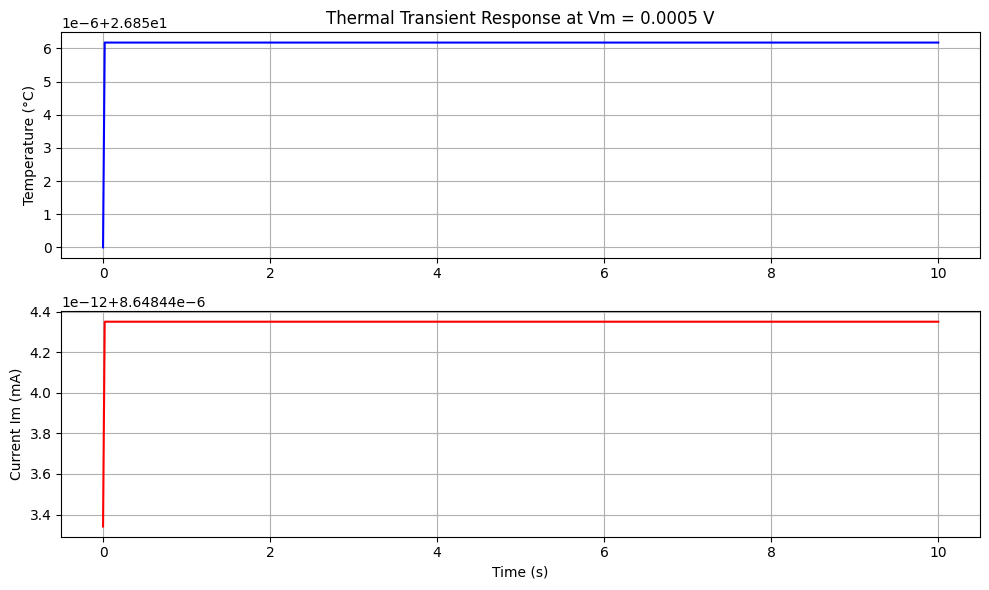

Final steady-state temperature: 300.00 K (26.85 °C)
Final steady-state current: 0.00 mA


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
# Use placeholder values (you should replace these with actual values)
# C_th = 0.01      # Thermal capacitance (J/K)
# g0 = 1.0e-3      # Conductance prefactor (S)
# g1 = 3000.0      # Activation energy parameter (K)
# g_th = 0.005     # Thermal conductance to ambient (W/K)
# T_amb = 293.15   # Ambient temperature (K, e.g., 20°C)
V_m_dc = 0.0005    # Fixed DC Voltage input (V)
g0=5e-3;
g1=1700;
C_th=1e-14;
g_th=0.7e-6;
T_amb=300;
# Rs= 200;

# Vb=1.5; Rb=2e3;

# --- 2. Define the System of Equations ---
def thermal_model_ode(T, t, V_m, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt (Equation 2 rearranged).

    Parameters:
    T: Current temperature (K). This is the state variable.
    t: Time (s).
    V_m, C_th, g0, g1, g_th, T_amb: Model constants.
    """

    # Equation 3: Conductance G(T)
    # The temperature T must be positive, which is true for Kelvin.
    G_T = g0 * np.exp(-g1 / T)

    # Equation 1 & 2: Power balance (P_in - P_out)
    # P_in = V_m * I_m = V_m * (V_m * G_T) = V_m**2 * G_T
    P_in = V_m**2 * G_T

    # P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 3. Simulation Setup ---

# Initial Condition: Assume the device starts at ambient temperature
T_initial = T_amb

# Time vector for the simulation (e.g., 0 to 10 seconds)
t = np.linspace(0, 10, 500)

# --- 4. Solve the ODE ---
# 'args' passes the model constants to the ODE function
T_transient = odeint(
    thermal_model_ode,
    T_initial,
    t,
    args=(V_m_dc, C_th, g0, g1, g_th, T_amb)
)

# Reshape the output for easier use (odeint returns an array of arrays)
T_transient = T_transient.flatten()

# --- 5. Calculate Current (Im) from Temperature ---
# We use the final temperature array to calculate the corresponding current array
def calculate_current(T, V_m, g0, g1):
    """Calculates Im = Vm * G(T)"""
    G_T = g0 * np.exp(-g1 / T)
    I_m = V_m * G_T
    return I_m

I_m_transient = calculate_current(T_transient, V_m_dc, g0, g1)

# --- 6. Plot the DC Transient Curve ---
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, T_transient - 273.15, 'b-') # Plot in Celsius for readability
plt.title(f'Thermal Transient Response at Vm = {V_m_dc} V')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, I_m_transient * 1000, 'r-') # Plot in mA for readability
plt.xlabel('Time (s)')
plt.ylabel('Current Im (mA)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final steady-state temperature: {T_transient[-1]:.2f} K ({T_transient[-1] - 273.15:.2f} °C)")
print(f"Final steady-state current: {I_m_transient[-1]*1000:.2f} mA")

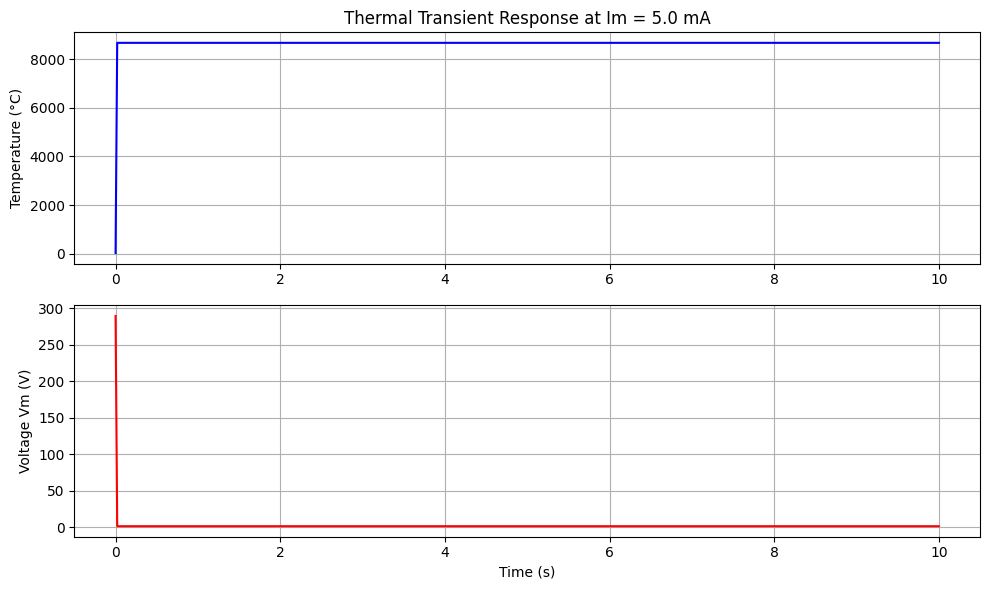

Fixed DC Current: 5.00 mA
Final steady-state temperature: 8939.03 K (8665.88 °C)
Final steady-state voltage: 1.21 V


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
# Using the same placeholder values as before
# C_th = 0.01      # Thermal capacitance (J/K)
# g0 = 1.0e-3      # Conductance prefactor (S)
# g1 = 3000.0      # Activation energy parameter (K)
# g_th = 0.005     # Thermal conductance to ambient (W/K)
# T_amb = 293.15   # Ambient temperature (K, e.g., 20°C)
g0=5e-3;
g1=1700;
C_th=1e-14;
g_th=0.7e-6;
T_amb=300;
I_m_dc = 0.005   # Fixed DC Current input (A) - e.g., 5 mA

# --- 2. Define the System of Equations (dT/dt) ---
def thermal_model_ode_constant_current(T, t, I_m, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the constant current case.

    Parameters:
    T: Current temperature (K).
    t: Time (s).
    I_m, C_th, g0, g1, g_th, T_amb: Model constants.
    """

    # Calculate Power Input P_in = Vm * Im.
    # Since Vm = Im / G(T) and G(T) = g0 * exp(-g1 / T),
    # P_in = Im * (Im / G(T)) = Im**2 / G(T) = (Im**2 / g0) * exp(g1 / T)

    # P_in Calculation
    P_in = (I_m**2 / g0) * np.exp(g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 3. Simulation Setup ---

# Initial Condition: Assume the device starts at ambient temperature
T_initial = T_amb

# Time vector for the simulation (e.g., 0 to 10 seconds)
t = np.linspace(0, 10, 500)

# --- 4. Solve the ODE ---
T_transient = odeint(
    thermal_model_ode_constant_current,
    T_initial,
    t,
    args=(I_m_dc, C_th, g0, g1, g_th, T_amb)
)

# Reshape the output for easier use
T_transient = T_transient.flatten()

# --- 5. Calculate Voltage (Vm) from Temperature ---
# We use the final temperature array to calculate the corresponding voltage array
def calculate_voltage(T, I_m, g0, g1):
    """Calculates Vm = Im / G(T)"""
    # G(T) = g0 * exp(-g1 / T)
    G_T = g0 * np.exp(-g1 / T)
    V_m = I_m / G_T
    return V_m

V_m_transient = calculate_voltage(T_transient, I_m_dc, g0, g1)

# --- 6. Plot the DC Transient Curve ---
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, T_transient - 273.15, 'b-') # Plot in Celsius
plt.title(f'Thermal Transient Response at Im = {I_m_dc * 1000} mA')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, V_m_transient, 'r-')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Vm (V)')
plt.grid(True)

plt.tight_layout()
plt.savefig("constant_current_transient.png")
plt.show()

print(f"Fixed DC Current: {I_m_dc * 1000:.2f} mA")
print(f"Final steady-state temperature: {T_transient[-1]:.2f} K ({T_transient[-1] - 273.15:.2f} °C)")
print(f"Final steady-state voltage: {V_m_transient[-1]:.2f} V")

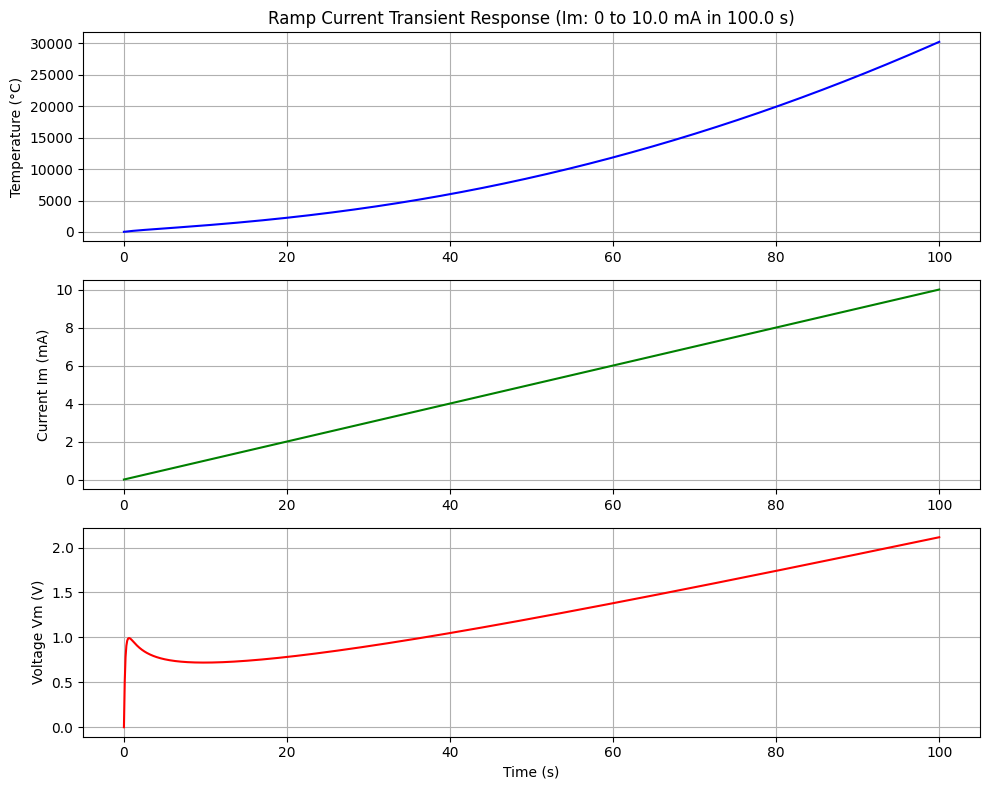

Ramp Slope: 0.1000 mA/s
Final Maximum Current: 10.00 mA
Final Steady-state Temperature: 30508.67 K (30235.52 °C)
Final Voltage: 2.11 V


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
# C_th = 0.01      # Thermal capacitance (J/K)
# g0 = 1.0e-3      # Conductance prefactor (S)
# g1 = 3000.0      # Activation energy parameter (K)
# g_th = 0.005     # Thermal conductance to ambient (W/K)
# T_amb = 293.15   # Ambient temperature (K, e.g., 20°C)
g0=5e-3;
g1=1700;
C_th=1e-14;
g_th=0.7e-6;
T_amb=300;


# --- 2. Define Ramp Parameters ---
T_max_simulation = 100.0 # Total simulation time (s) for low frequency
I_max_ramp = 0.01      # Maximum current reached (A)
ramp_slope = I_max_ramp / T_max_simulation # Ramp slope (A/s)

# --- 3. Ramp Current Function I_m(t) ---
def I_m_ramp(t, ramp_slope, I_max):
    """Calculates the instantaneous ramp current, limited by I_max."""
    # Current increases linearly with time, but is clipped at I_max
    return np.clip(ramp_slope * t, 0, I_max)

# --- 4. Define the System of Equations (dT/dt) ---
def thermal_model_ode_ramp_current(T, t, ramp_slope, I_max, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the time-dependent ramp current case.

    The instantaneous current I_m(t) is calculated inside this function.
    """

    # Calculate I_m(t) at the current time t
    I_m = I_m_ramp(t, ramp_slope, I_max)

    # Calculate Power Input P_in = I_m^2 / G(T)
    # G(T) = g0 * exp(-g1 / T)

    # Calculate Power Input P_in = Vm * Im = Im**2 / G(T)
    # We can skip the `if I_m == 0` check if we use a small value for g0 * exp(-g1 / T) to avoid Inf,
    # but since I_m starts at zero, the condition is clearer.
    if I_m == 0:
        P_in = 0.0
    else:
        # P_in = (I_m**2 / g0) * exp(g1 / T)
        P_in = (I_m**2 / g0) * np.exp(g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 5. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector

# Solve the ODE
T_transient = odeint(
    thermal_model_ode_ramp_current,
    T_initial,
    t,
    args=(ramp_slope, I_max_ramp, C_th, g0, g1, g_th, T_amb)
)
T_transient = T_transient.flatten()

# --- 6. Calculate I_m(t) and V_m(t) ---

# I_m(t) at all time steps
I_m_transient = I_m_ramp(t, ramp_slope, I_max_ramp)

# V_m(t) calculation: Vm = Im / G(T) = (Im / g0) * exp(g1 / T)
def calculate_voltage(T, I_m, g0, g1):
    """Calculates Vm = Im / G(T)"""
    # G(T) = g0 * exp(-g1 / T)
    G_T = g0 * np.exp(-g1 / T)
    V_m = I_m / G_T
    return V_m

V_m_transient = calculate_voltage(T_transient, I_m_transient, g0, g1)

# --- 7. Plot the DC Transient Curve ---
plt.figure(figsize=(10, 8))

# Subplot 1: Temperature
plt.subplot(3, 1, 1)
plt.plot(t, T_transient - 273.15, 'b-')
plt.title(f'Ramp Current Transient Response (Im: 0 to {I_max_ramp * 1000} mA in {T_max_simulation} s)')
plt.ylabel('Temperature (°C)')
plt.grid(True)

# Subplot 2: Current (Input)
plt.subplot(3, 1, 2)
plt.plot(t, I_m_transient * 1000, 'g-')
plt.ylabel('Current Im (mA)')
plt.grid(True)

# Subplot 3: Voltage (Output)
plt.subplot(3, 1, 3)
plt.plot(t, V_m_transient, 'r-')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Vm (V)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Ramp Slope: {ramp_slope*1000:.4f} mA/s")
print(f"Final Maximum Current: {I_m_transient[-1]*1000:.2f} mA")
print(f"Final Steady-state Temperature: {T_transient[-1]:.2f} K ({T_transient[-1] - 273.15:.2f} °C)")
print(f"Final Voltage: {V_m_transient[-1]:.2f} V")

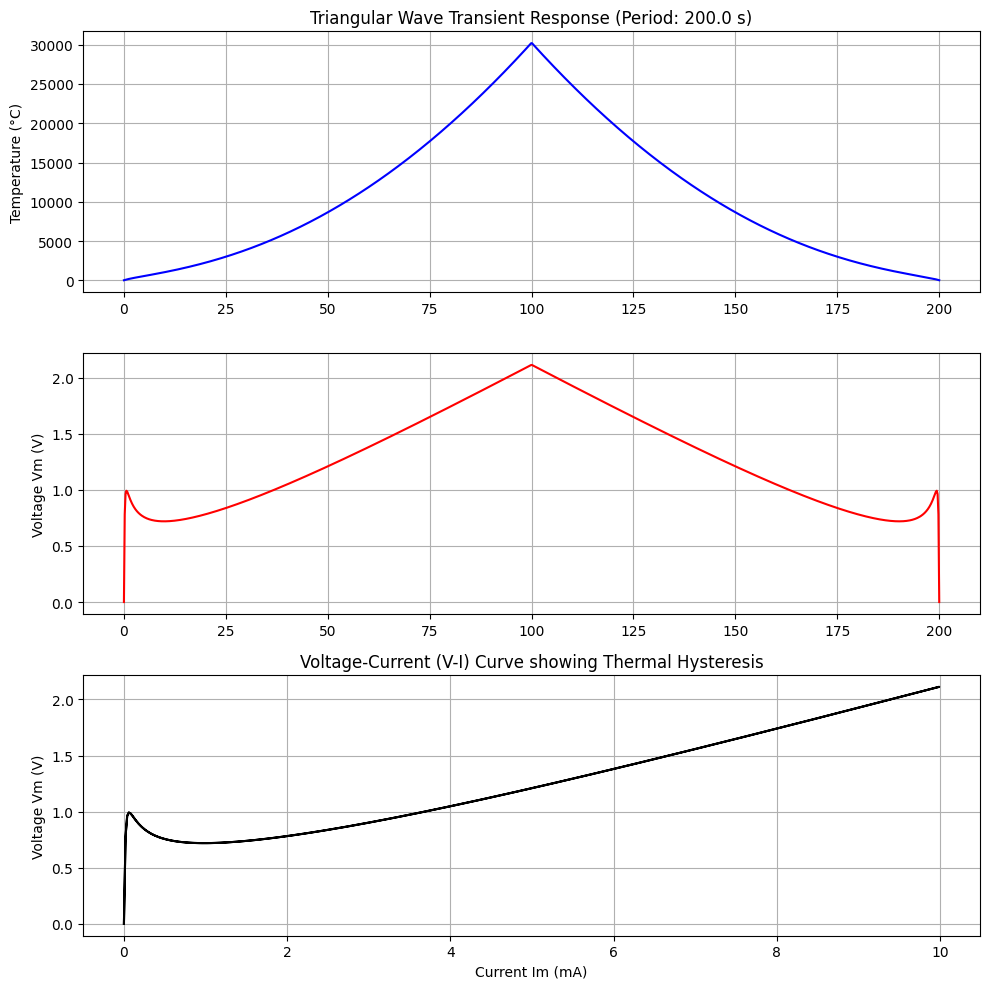

Cycle Period: 200.0 s
Peak Current: 10.00 mA
Max Temperature Reached: 30451.39 K (30178.24 °C)


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
# C_th = 0.01      # Thermal capacitance (J/K)
# g0 = 1.0e-3      # Conductance prefactor (S)
# g1 = 3000.0      # Activation energy parameter (K)
# g_th = 0.005     # Thermal conductance to ambient (W/K)
# T_amb = 293.15   # Ambient temperature (K, e.g., 20°C)
g0=5e-3;
g1=1700;
C_th=1e-14;
g_th=0.7e-6;
T_amb=300;

# --- 2. Define Triangular Wave Parameters ---
I_max_peak = 0.01      # Peak current (A)
T_cycle = 200.0        # Total time for one cycle (s)
t_ramp = T_cycle / 2.0 # Time for upward ramp (100.0 s)
ramp_slope = I_max_peak / t_ramp # Slope magnitude (A/s)

T_max_simulation = T_cycle # Simulate for one full cycle

# --- 3. Triangular Current Function I_m(t) ---
def I_m_triangular(t, ramp_slope, I_max, t_ramp, T_cycle):
    """Calculates the instantaneous triangular current wave."""

    # Use modulo to handle continuous cycles (though we only simulate one)
    t_mod = np.fmod(t, T_cycle)

    if t_mod <= t_ramp:
        # Upward ramp phase: I_m = slope * t
        I_m = ramp_slope * t_mod
    else:
        # Downward ramp phase: I_m starts from I_max and goes down to 0
        # Time into the downward ramp: (t_mod - t_ramp)
        # Current = I_max - (slope * time_into_downward_ramp)
        I_m = I_max - ramp_slope * (t_mod - t_ramp)

    # Ensure current is non-negative due to float precision
    return max(0.0, I_m)

# --- 4. Define the System of Equations (dT/dt) ---
def thermal_model_ode_triangular_current(T, t, ramp_slope, I_max, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the time-dependent triangular current case.
    """

    # Calculate I_m(t) at the current time t
    I_m = I_m_triangular(t, ramp_slope, I_max, t_ramp, T_cycle)

    # Calculate Power Input P_in = I_m^2 / G(T)
    if I_m == 0:
        P_in = 0.0
    else:
        # P_in = (I_m**2 / g0) * exp(g1 / T)
        P_in = (I_m**2 / g0) * np.exp(g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 5. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector for the full cycle

# Solve the ODE
T_transient = odeint(
    thermal_model_ode_triangular_current,
    T_initial,
    t,
    args=(ramp_slope, I_max_peak, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb)
)
T_transient = T_transient.flatten()

# --- 6. Calculate I_m(t) and V_m(t) ---

# I_m(t) at all time steps
I_m_transient = np.array([I_m_triangular(ti, ramp_slope, I_max_peak, t_ramp, T_cycle) for ti in t])

# V_m(t) calculation: Vm = Im / G(T) = (Im / g0) * exp(g1 / T)
def calculate_voltage(T, I_m, g0, g1):
    """Calculates Vm = Im / G(T)"""
    G_T = g0 * np.exp(-g1 / T)
    # Ensure V_m is 0 when I_m is 0
    V_m = np.where(I_m > 0, I_m / G_T, 0.0)
    return V_m

V_m_transient = calculate_voltage(T_transient, I_m_transient, g0, g1)

# --- 7. Plot the Transients (T vs t, Vm vs t) and the Hysteresis (Vm vs Im) ---
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Subplot 1: Temperature vs Time
axes[0].plot(t, T_transient - 273.15, 'b-')
axes[0].set_title(f'Triangular Wave Transient Response (Period: {T_cycle} s)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True)

# Subplot 2: Voltage vs Time
axes[1].plot(t, V_m_transient, 'r-')
axes[1].set_ylabel('Voltage Vm (V)')
axes[1].grid(True)

# Subplot 3: V-I Curve (Hysteresis Loop)
axes[2].plot(I_m_transient * 1000, V_m_transient, 'k-')
axes[2].set_xlabel('Current Im (mA)')
axes[2].set_ylabel('Voltage Vm (V)')
axes[2].set_title('Voltage-Current (V-I) Curve showing Thermal Hysteresis')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"Cycle Period: {T_cycle:.1f} s")
print(f"Peak Current: {I_max_peak*1000:.2f} mA")
print(f"Max Temperature Reached: {T_transient.max():.2f} K ({T_transient.max() - 273.15:.2f} °C)")

/tmp/ipython-input-2482801480.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


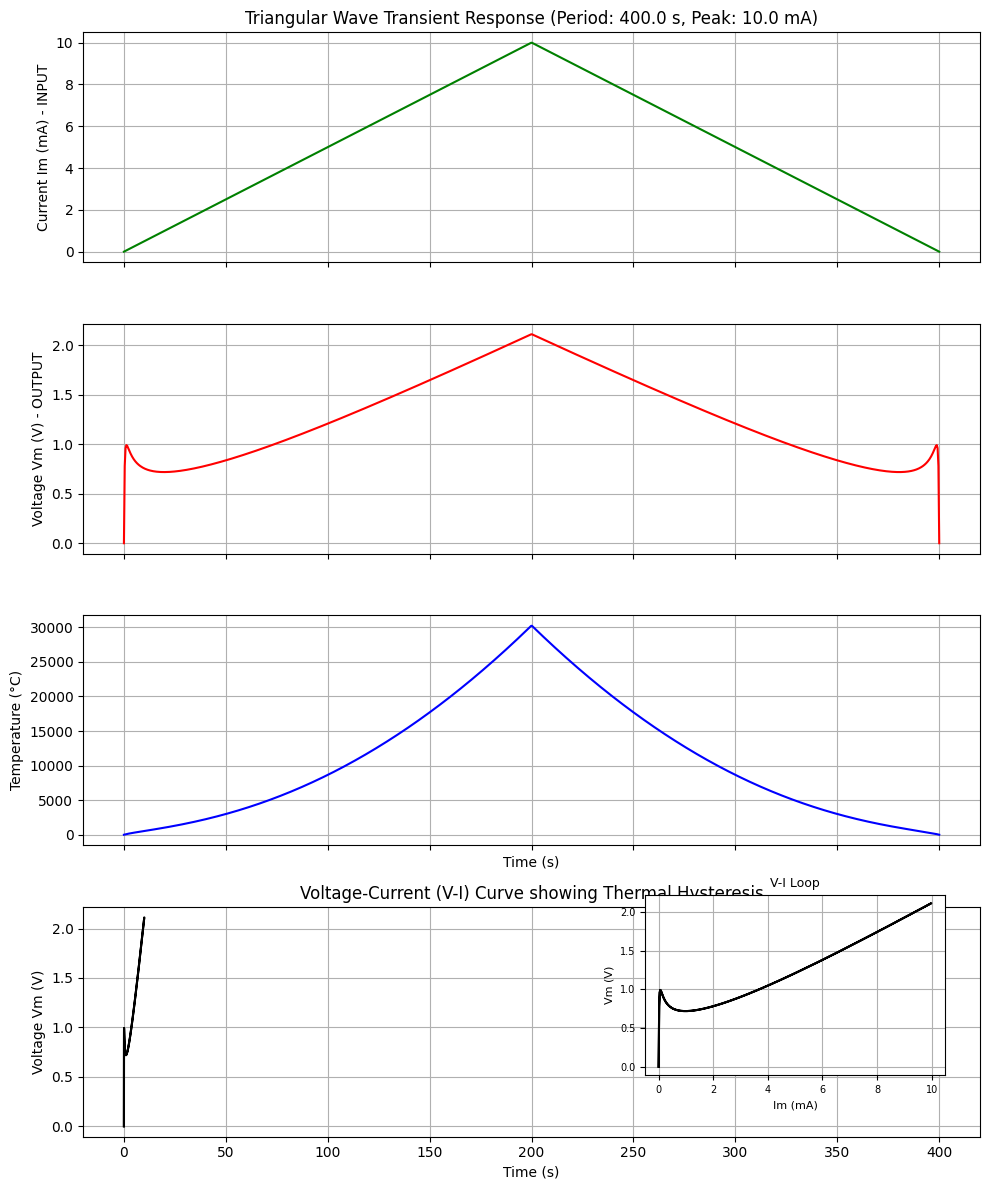

Thermal Time Constant (C_th / g_th): 1.43e-08 seconds
Cycle Period: 400.0 s
-----------------------------------
Peak Current: 10.00 mA
Max Temperature Reached: 30451.39 K (30178.24 °C)
Voltage at Peak Current: 2.11 V


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# --- 2. Define Triangular Wave Parameters ---
I_max_peak = 0.01      # Peak current (A)
T_cycle = 400.0        # Total time for one cycle (s)
t_ramp = T_cycle / 2.0 # Time for upward ramp (100.0 s)
ramp_slope = I_max_peak / t_ramp # Slope magnitude (A/s)

T_max_simulation = T_cycle # Simulate for one full cycle

# --- 3. Triangular Current Function I_m(t) ---
def I_m_triangular(t, ramp_slope, I_max, t_ramp, T_cycle):
    """Calculates the instantaneous triangular current wave."""

    t_mod = np.fmod(t, T_cycle)

    if t_mod <= t_ramp:
        # Upward ramp phase: I_m = slope * t
        I_m = ramp_slope * t_mod
    else:
        # Downward ramp phase
        I_m = I_max - ramp_slope * (t_mod - t_ramp)

    return max(0.0, I_m)

# --- 4. Define the System of Equations (dT/dt) ---
def thermal_model_ode_triangular_current(T, t, ramp_slope, I_max, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the time-dependent triangular current case.
    """

    I_m = I_m_triangular(t, ramp_slope, I_max, t_ramp, T_cycle)

    # Calculate Power Input P_in = I_m^2 / G(T)
    if I_m == 0:
        P_in = 0.0
    else:
        # P_in = (I_m**2 / g0) * exp(g1 / T)
        # Note: Given the parameters, the Max Temperature Reached is very high (~30000 K)
        # We handle this large number, but it suggests the model parameters might be non-physical for this current level.
        P_in = (I_m**2 / g0) * np.exp(g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 5. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector for the full cycle

# Solve the ODE
T_transient = odeint(
    thermal_model_ode_triangular_current,
    T_initial,
    t,
    args=(ramp_slope, I_max_peak, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb)
)
T_transient = T_transient.flatten()

# --- 6. Calculate I_m(t) and V_m(t) ---

I_m_transient = np.array([I_m_triangular(ti, ramp_slope, I_max_peak, t_ramp, T_cycle) for ti in t])

def calculate_voltage(T, I_m, g0, g1):
    """Calculates Vm = Im / G(T)"""
    G_T = g0 * np.exp(-g1 / T)
    V_m = np.where(I_m > 0, I_m / G_T, 0.0)
    return V_m

V_m_transient = calculate_voltage(T_transient, I_m_transient, g0, g1)

# --- 7. Plotting the Results ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Current vs Time (Input Signal) 🟢
axes[0].plot(t, I_m_transient * 1000, 'g-')
axes[0].set_title(f'Triangular Wave Transient Response (Period: {T_cycle} s, Peak: {I_max_peak * 1000} mA)')
axes[0].set_ylabel('Current Im (mA) - INPUT')
axes[0].grid(True)

# Subplot 2: Voltage vs Time (Output Signal) 🔴
axes[1].plot(t, V_m_transient, 'r-')
axes[1].set_ylabel('Voltage Vm (V) - OUTPUT')
axes[1].grid(True)

# Subplot 3: Temperature vs Time 🔵
axes[2].plot(t, T_transient - 273.15, 'b-')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True)

# Subplot 4: V-I Curve (Hysteresis Loop) ⚫
axes[3].plot(I_m_transient * 1000, V_m_transient, 'k-')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Voltage Vm (V)')
axes[3].set_title('Voltage-Current (V-I) Curve showing Thermal Hysteresis')
axes[3].grid(True)

# Add an I-V plot in the bottom right corner for better visualization of the loop
ax_iv = fig.add_axes([0.65, 0.1, 0.3, 0.15]) # [left, bottom, width, height]
ax_iv.plot(I_m_transient * 1000, V_m_transient, 'k-')
ax_iv.set_xlabel('Im (mA)', fontsize=8)
ax_iv.set_ylabel('Vm (V)', fontsize=8)
ax_iv.set_title('V-I Loop', fontsize=9)
ax_iv.tick_params(axis='both', which='major', labelsize=7)
ax_iv.grid(True)

axes[2].set_xlabel('Time (s)') # Set shared x-axis label on the third plot

plt.tight_layout()
plt.show()

# --- 8. Final Print Statements (Fixed Indexing) ---

# Thermal time constant is very small, leading to near-zero hysteresis.
print(f"Thermal Time Constant (C_th / g_th): {C_th / g_th:.2e} seconds")
print(f"Cycle Period: {T_cycle:.1f} s")
print("-" * 35)
print(f"Peak Current: {I_max_peak*1000:.2f} mA")
print(f"Max Temperature Reached: {T_transient.max():.2f} K ({T_transient.max() - 273.15:.2f} °C)")

# Fix for IndexError: Find the index where time 't' is closest to t_ramp (100.0 s)
peak_time_index = np.argmin(np.abs(t - t_ramp))
voltage_at_peak = V_m_transient[peak_time_index]
print(f"Voltage at Peak Current: {voltage_at_peak:.2f} V")

/tmp/ipython-input-3660242057.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


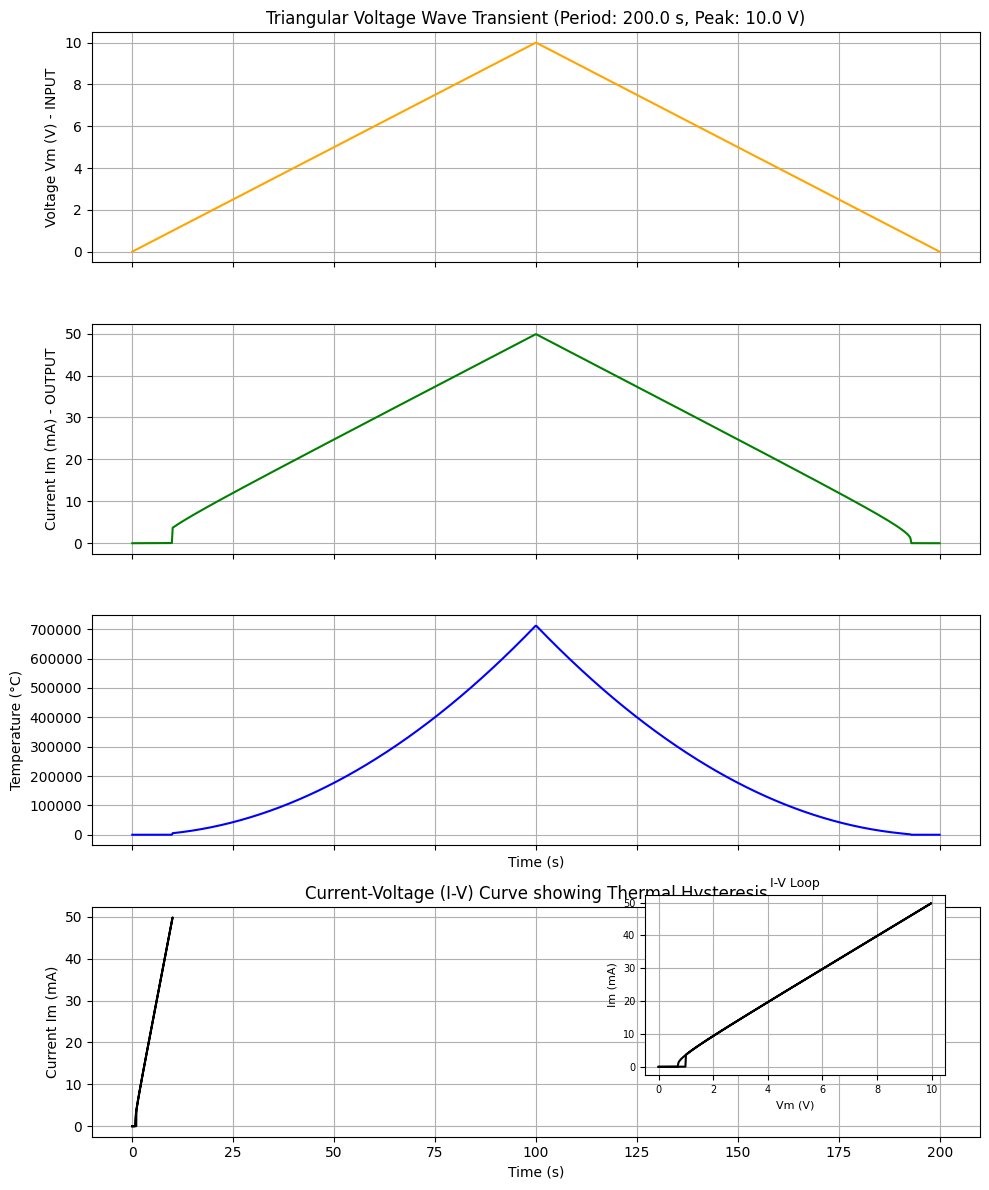

Thermal Time Constant (C_th / g_th): 1.43e-08 seconds
Cycle Period: 200.0 s
-----------------------------------
Peak Voltage: 10.00 V
Max Temperature Reached: 711455.11 K (711181.96 °C)
Current at Peak Voltage: 49.83 mA


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# --- 2. Define Triangular Wave Parameters ---
V_max_peak = 10.0      # Peak voltage (V)
T_cycle = 200.0        # Total time for one cycle (s)
t_ramp = T_cycle / 2.0 # Time for upward ramp (100.0 s)
ramp_slope = V_max_peak / t_ramp # Slope magnitude (V/s)

T_max_simulation = T_cycle # Simulate for one full cycle

# --- 3. Triangular Voltage Function V_m(t) ---
def V_m_triangular(t, ramp_slope, V_max, t_ramp, T_cycle):
    """Calculates the instantaneous triangular voltage wave."""

    t_mod = np.fmod(t, T_cycle)

    if t_mod <= t_ramp:
        # Upward ramp phase: V_m = slope * t
        V_m = ramp_slope * t_mod
    else:
        # Downward ramp phase
        V_m = V_max - ramp_slope * (t_mod - t_ramp)

    return max(0.0, V_m)

# --- 4. Define the System of Equations (dT/dt) ---
def thermal_model_ode_triangular_voltage(T, t, ramp_slope, V_max, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the time-dependent triangular voltage case.
    """

    # Calculate V_m(t) at the current time t
    V_m = V_m_triangular(t, ramp_slope, V_max, t_ramp, T_cycle)

    # Calculate Power Input P_in = V_m^2 * G(T)
    # G(T) = g0 * exp(-g1 / T)
    P_in = V_m**2 * g0 * np.exp(-g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 5. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector for the full cycle

# Solve the ODE
T_transient = odeint(
    thermal_model_ode_triangular_voltage,
    T_initial,
    t,
    args=(ramp_slope, V_max_peak, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb)
)
T_transient = T_transient.flatten()

# --- 6. Calculate V_m(t) and I_m(t) ---

# V_m(t) at all time steps
V_m_transient = np.array([V_m_triangular(ti, ramp_slope, V_max_peak, t_ramp, T_cycle) for ti in t])

# I_m(t) calculation: Im = Vm * G(T) = Vm * g0 * exp(-g1 / T)
def calculate_current(T, V_m, g0, g1):
    """Calculates Im = Vm * G(T)"""
    G_T = g0 * np.exp(-g1 / T)
    I_m = V_m * G_T
    return I_m

I_m_transient = calculate_current(T_transient, V_m_transient, g0, g1)

# --- 7. Plotting the Results ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Voltage vs Time (Input Signal) 🟡
axes[0].plot(t, V_m_transient, color='orange')
axes[0].set_title(f'Triangular Voltage Wave Transient (Period: {T_cycle} s, Peak: {V_max_peak} V)')
axes[0].set_ylabel('Voltage Vm (V) - INPUT')
axes[0].grid(True)

# Subplot 2: Current vs Time (Output Signal) 🟢
axes[1].plot(t, I_m_transient * 1000, 'g-')
axes[1].set_ylabel('Current Im (mA) - OUTPUT')
axes[1].grid(True)

# Subplot 3: Temperature vs Time 🔵
axes[2].plot(t, T_transient - 273.15, 'b-')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True)

# Subplot 4: I-V Curve (Hysteresis Loop) ⚫
axes[3].plot(V_m_transient, I_m_transient * 1000, 'k-') # I vs V for standard I-V
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Current Im (mA)')
axes[3].set_title('Current-Voltage (I-V) Curve showing Thermal Hysteresis')
axes[3].grid(True)

# Add an I-V plot in the bottom right corner for better visualization of the loop
ax_iv = fig.add_axes([0.65, 0.1, 0.3, 0.15]) # [left, bottom, width, height]
ax_iv.plot(V_m_transient, I_m_transient * 1000, 'k-')
ax_iv.set_xlabel('Vm (V)', fontsize=8)
ax_iv.set_ylabel('Im (mA)', fontsize=8)
ax_iv.set_title('I-V Loop', fontsize=9)
ax_iv.tick_params(axis='both', which='major', labelsize=7)
ax_iv.grid(True)

axes[2].set_xlabel('Time (s)') # Set shared x-axis label on the third plot

plt.tight_layout()
plt.show()

# --- 8. Final Print Statements ---

# Fix for Index Error (Finding the peak time index)
peak_time_index = np.argmin(np.abs(t - t_ramp))
current_at_peak = I_m_transient[peak_time_index]

print(f"Thermal Time Constant (C_th / g_th): {C_th / g_th:.2e} seconds")
print(f"Cycle Period: {T_cycle:.1f} s")
print("-" * 35)
print(f"Peak Voltage: {V_max_peak:.2f} V")
print(f"Max Temperature Reached: {T_transient.max():.2f} K ({T_transient.max() - 273.15:.2f} °C)")
print(f"Current at Peak Voltage: {current_at_peak*1000:.2f} mA")

<>:108: SyntaxWarning: invalid escape sequence '\O'
<>:108: SyntaxWarning: invalid escape sequence '\O'
<>:108: SyntaxWarning: invalid escape sequence '\O'
<>:108: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-2765969828.py:108: SyntaxWarning: invalid escape sequence '\O'
  axes[0].set_title(f'Biased Memristor Circuit Response (V_b Peak: {V_b_peak} V, Rs: {R_s} $\Omega$, Rb: {R_b} $\Omega$)')
/tmp/ipython-input-2765969828.py:108: SyntaxWarning: invalid escape sequence '\O'
  axes[0].set_title(f'Biased Memristor Circuit Response (V_b Peak: {V_b_peak} V, Rs: {R_s} $\Omega$, Rb: {R_b} $\Omega$)')


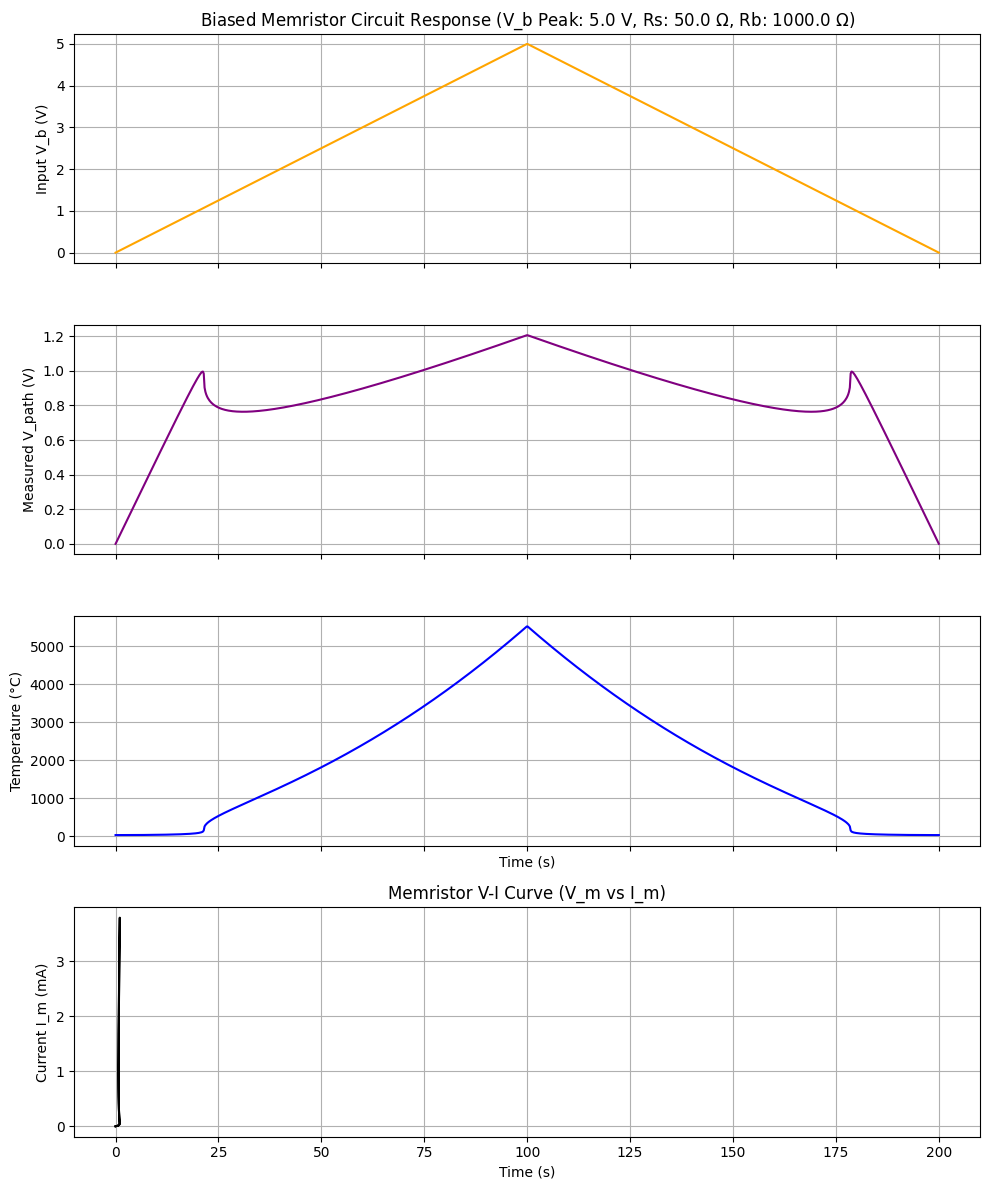

Thermal Time Constant (C_th / g_th): 1.43e-08 seconds
Cycle Period: 200.0 s
-----------------------------------
Peak V_b: 5.00 V
Max Temperature Reached: 5800.27 K (5527.12 °C)
Path Voltage V_path at V_b peak: 1.21 V
Path Current I_m at V_b peak: 3.79 mA


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Device and Biasing Constants ---
# Device Parameters (as specified)
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# Circuit Parameters
R_b = 1000.0     # Biasing Resistor (Ohms)
R_s = 50.0       # Series Resistor (Ohms)

# --- 2. Define Input Sweep Signal (Triangular Wave for V_b) ---
V_b_peak = 5.0         # Peak Biasing Voltage (V)
T_cycle = 200.0        # Total time for one cycle (s)
t_ramp = T_cycle / 2.0 # Time for upward ramp (100.0 s)
ramp_slope = V_b_peak / t_ramp # Slope magnitude (V/s)
T_max_simulation = T_cycle

def V_b_triangular(t, ramp_slope, V_peak, t_ramp, T_cycle):
    """Calculates the instantaneous triangular biasing voltage V_b(t)."""
    t_mod = np.fmod(t, T_cycle)
    if t_mod <= t_ramp:
        V_b = ramp_slope * t_mod
    else:
        V_b = V_peak - ramp_slope * (t_mod - t_ramp)
    return max(0.0, V_b)

# --- 3. Define the ODE (dT/dt) ---
def memristor_circuit_ode(T, t, g0, g1, C_th, g_th, T_amb, R_b, R_s, ramp_slope, V_b_peak, t_ramp, T_cycle):
    """
    Returns the derivative dT/dt for the biased series circuit.

    T: Current temperature (K).
    """

    # 3a. Calculate instantaneous input V_b
    V_b = V_b_triangular(t, ramp_slope, V_b_peak, t_ramp, T_cycle)

    # 3b. Calculate Memristor Resistance R_m(T) and Conductance G(T)
    G_T = g0 * np.exp(-g1 / T)

    # Avoid division by zero when G_T is extremely small, though G_T is always positive here
    R_m_T = 1.0 / G_T

    # 3c. Calculate Path Current I_m (I_path)
    # I_path = V_b / (R_b + R_s + R_m(T))
    I_m = V_b / (R_b + R_s + R_m_T)

    # 3d. Calculate Memristor Voltage V_m (V_m = I_m * R_m(T))
    V_m = I_m * R_m_T

    # 3e. Power Balance (P_in = V_m * I_m)
    P_in = V_m * I_m
    P_out = g_th * (T - T_amb)

    # dT/dt
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 4. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector

# Solve the ODE
T_transient = odeint(
    memristor_circuit_ode,
    T_initial,
    t,
    args=(g0, g1, C_th, g_th, T_amb, R_b, R_s, ramp_slope, V_b_peak, t_ramp, T_cycle)
)
T_transient = T_transient.flatten()

# --- 5. Calculate Output Signals (V_path and I_path) ---

# Re-calculate intermediate values using the solution T_transient
def calculate_output_signals(t, T, g0, g1, R_b, R_s, ramp_slope, V_b_peak, t_ramp, T_cycle):
    V_b = np.array([V_b_triangular(ti, ramp_slope, V_b_peak, t_ramp, T_cycle) for ti in t])
    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T

    # Path Current: I_m = V_b / (R_b + R_s + R_m_T)
    I_m = V_b / (R_b + R_s + R_m_T)

    # Measured Voltage: V_path = I_m * (R_m_T + R_s)
    V_path = I_m * (R_m_T + R_s)

    # Memristor Voltage: V_m = I_m * R_m_T
    V_m = I_m * R_m_T

    return V_b, I_m, V_path, V_m

V_b_transient, I_m_transient, V_path_transient, V_m_transient = calculate_output_signals(
    t, T_transient, g0, g1, R_b, R_s, ramp_slope, V_b_peak, t_ramp, T_cycle
)

# --- 6. Plotting the Results ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Input Voltage V_b vs Time 🟡
axes[0].plot(t, V_b_transient, color='orange')
axes[0].set_title(f'Biased Memristor Circuit Response (V_b Peak: {V_b_peak} V, Rs: {R_s} $\Omega$, Rb: {R_b} $\Omega$)')
axes[0].set_ylabel('Input V_b (V)')
axes[0].grid(True)

# Subplot 2: Measured Path Voltage V_path vs Time 🟣
axes[1].plot(t, V_path_transient, color='purple')
axes[1].set_ylabel('Measured V_path (V)')
axes[1].grid(True)

# Subplot 3: Temperature vs Time 🔵
axes[2].plot(t, T_transient - 273.15, 'b-')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True)

# Subplot 4: Memristor V-I Curve (V_m vs I_m) ⚫
axes[3].plot(V_m_transient, I_m_transient * 1000, 'k-')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Current I_m (mA)')
axes[3].set_title('Memristor V-I Curve (V_m vs I_m)')
axes[3].grid(True)

axes[2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

# --- 7. Final Print Statements ---
print(f"Thermal Time Constant (C_th / g_th): {C_th / g_th:.2e} seconds")
print(f"Cycle Period: {T_cycle:.1f} s")
print("-" * 35)

peak_time_index = np.argmin(np.abs(t - t_ramp))
V_path_at_peak = V_path_transient[peak_time_index]
I_m_at_peak = I_m_transient[peak_time_index]

print(f"Peak V_b: {V_b_peak:.2f} V")
print(f"Max Temperature Reached: {T_transient.max():.2f} K ({T_transient.max() - 273.15:.2f} °C)")
print(f"Path Voltage V_path at V_b peak: {V_path_at_peak:.2f} V")
print(f"Path Current I_m at V_b peak: {I_m_at_peak*1000:.2f} mA")

<>:96: SyntaxWarning: invalid escape sequence '\O'
<>:96: SyntaxWarning: invalid escape sequence '\O'
<>:96: SyntaxWarning: invalid escape sequence '\O'
<>:96: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-1499488625.py:96: SyntaxWarning: invalid escape sequence '\O'
  axes[0].set_title(f'DC Transient Response (V_b = {V_b_dc} V, Rs={R_s} $\Omega$, Rb={R_b} $\Omega$)')
/tmp/ipython-input-1499488625.py:96: SyntaxWarning: invalid escape sequence '\O'
  axes[0].set_title(f'DC Transient Response (V_b = {V_b_dc} V, Rs={R_s} $\Omega$, Rb={R_b} $\Omega$)')


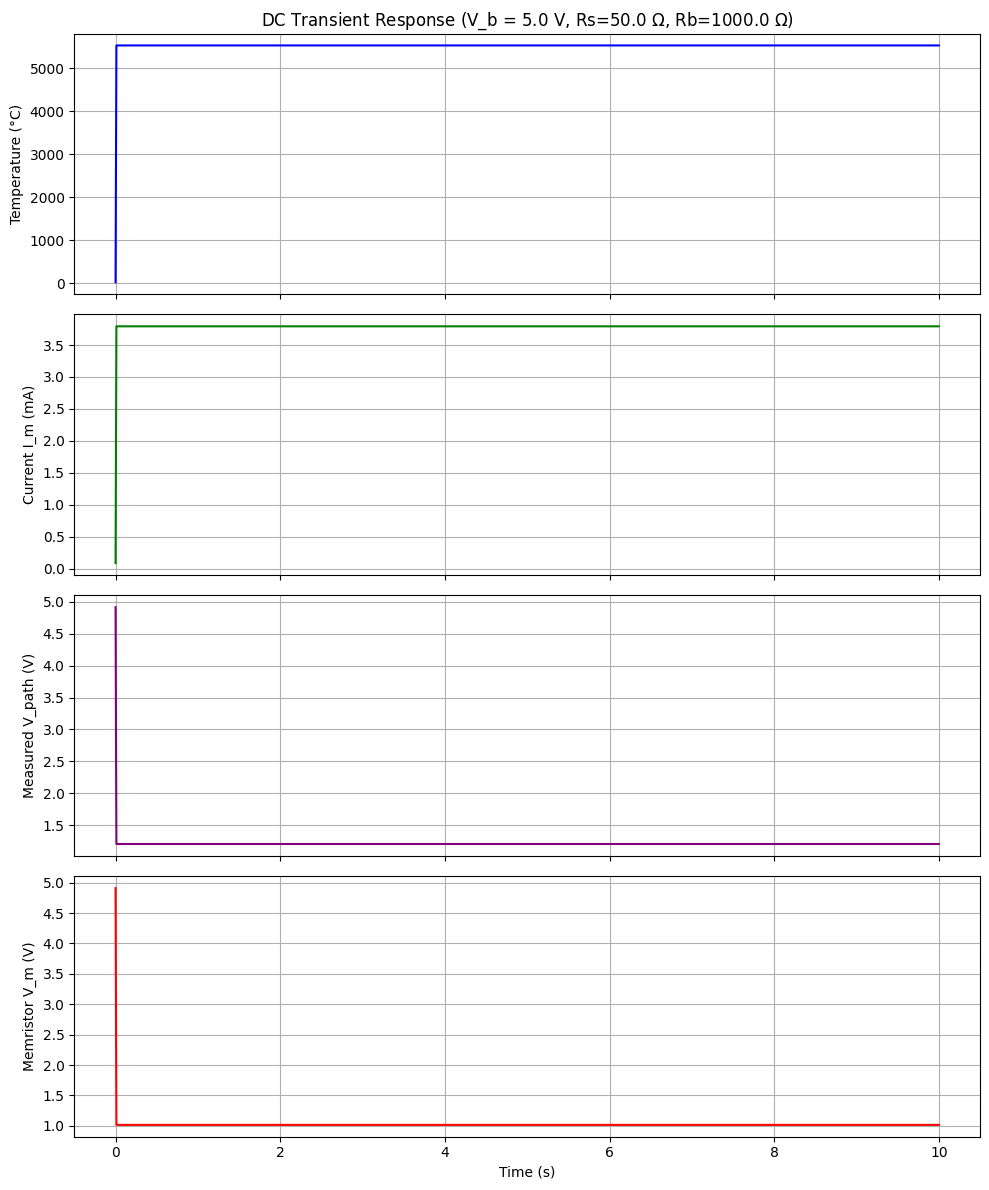

DC Biasing Voltage V_b: 5.00 V
Thermal Time Constant: 1.43e-08 seconds (Instantaneous response)
-----------------------------------
Initial State (t=0):
  Current I_m: 0.0849 mA
  Temperature T: 26.85 °C
-----------------------------------
Final Steady State (t=10.0 s):
  Current I_m: 3.7937 mA
  Temperature T: 5536.59 °C
  Measured V_path: 1.21 V
  Memristor V_m: 1.02 V


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Device and Biasing Constants ---
# Device Parameters (as specified)
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# Circuit Parameters
R_b = 1000.0     # Biasing Resistor (Ohms)
R_s = 50.0       # Series Resistor (Ohms)

# Input Parameter (Constant DC Biasing Voltage)
V_b_dc = 5.0     # Fixed DC Biasing Voltage (V)

# Simulation Setup
T_max_simulation = 10.0 # Total simulation time (s). Reduced time as response is very fast.

# --- 2. Define the ODE (dT/dt) ---
def memristor_circuit_ode_dc_bias(T, t, g0, g1, C_th, g_th, T_amb, R_b, R_s, V_b):
    """
    Returns the derivative dT/dt for the biased series circuit with constant V_b.

    T: Current temperature (K).
    t: Time (s).
    V_b: Constant Biasing Voltage (V).
    """

    # 2a. Calculate Memristor Resistance R_m(T)
    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T

    # 2b. Calculate Path Current I_m (I_path)
    # I_path = V_b / (R_b + R_s + R_m(T))
    # This calculation correctly includes all series resistances.
    I_m = V_b / (R_b + R_s + R_m_T)

    # 2c. Calculate Memristor Voltage V_m (V_m = I_m * R_m(T))
    V_m = I_m * R_m_T

    # 2d. Power Balance (P_in = V_m * I_m)
    P_in = V_m * I_m
    P_out = g_th * (T - T_amb)

    # dT/dt
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 3. Simulation Setup and Solution ---

T_initial = T_amb
# Time vector for the simulation (0 to 10 seconds)
t = np.linspace(0, T_max_simulation, 1000)

# Solve the ODE
T_transient = odeint(
    memristor_circuit_ode_dc_bias,
    T_initial,
    t,
    args=(g0, g1, C_th, g_th, T_amb, R_b, R_s, V_b_dc)
)
T_transient = T_transient.flatten()

# --- 4. Calculate Output Signals (V_path, I_path, V_m) ---

# Re-calculate intermediate values using the solution T_transient
def calculate_output_signals_dc(T, V_b, g0, g1, R_b, R_s):
    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T

    # Path Current: I_m = V_b / (R_b + R_s + R_m_T)
    I_m = V_b / (R_b + R_s + R_m_T)

    # Measured Voltage: V_path = I_m * (R_m_T + R_s)
    V_path = I_m * (R_m_T + R_s)

    # Memristor Voltage: V_m = I_m * R_m_T
    V_m = I_m * R_m_T

    return I_m, V_path, V_m

I_m_transient, V_path_transient, V_m_transient = calculate_output_signals_dc(
    T_transient, V_b_dc, g0, g1, R_b, R_s
)

# --- 5. Plotting the Results ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Temperature vs Time 🔵
axes[0].plot(t, T_transient - 273.15, 'b-')
axes[0].set_title(f'DC Transient Response (V_b = {V_b_dc} V, Rs={R_s} $\Omega$, Rb={R_b} $\Omega$)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True)

# Subplot 2: Current I_m vs Time 🟢
axes[1].plot(t, I_m_transient * 1000, 'g-')
axes[1].set_ylabel('Current I_m (mA)')
axes[1].grid(True)

# Subplot 3: Measured V_path vs Time 🟣 (Voltage across Rs + Memristor)
axes[2].plot(t, V_path_transient, color='purple')
axes[2].set_ylabel('Measured V_path (V)')
axes[2].grid(True)

# Subplot 4: Memristor Voltage V_m vs Time 🔴 (Voltage across Memristor only)
axes[3].plot(t, V_m_transient, 'r-')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Memristor V_m (V)')
axes[3].grid(True)

plt.tight_layout()
plt.show()

# --- 6. Final Print Statements ---

print(f"DC Biasing Voltage V_b: {V_b_dc:.2f} V")
print(f"Thermal Time Constant: {C_th / g_th:.2e} seconds (Instantaneous response)")
print("-" * 35)
print(f"Initial State (t=0):")
print(f"  Current I_m: {I_m_transient[0]*1000:.4f} mA")
print(f"  Temperature T: {T_transient[0] - 273.15:.2f} °C")
print("-" * 35)
print(f"Final Steady State (t={T_max_simulation:.1f} s):")
print(f"  Current I_m: {I_m_transient[-1]*1000:.4f} mA")
print(f"  Temperature T: {T_transient[-1] - 273.15:.2f} °C")
print(f"  Measured V_path: {V_path_transient[-1]:.2f} V")
print(f"  Memristor V_m: {V_m_transient[-1]:.2f} V")

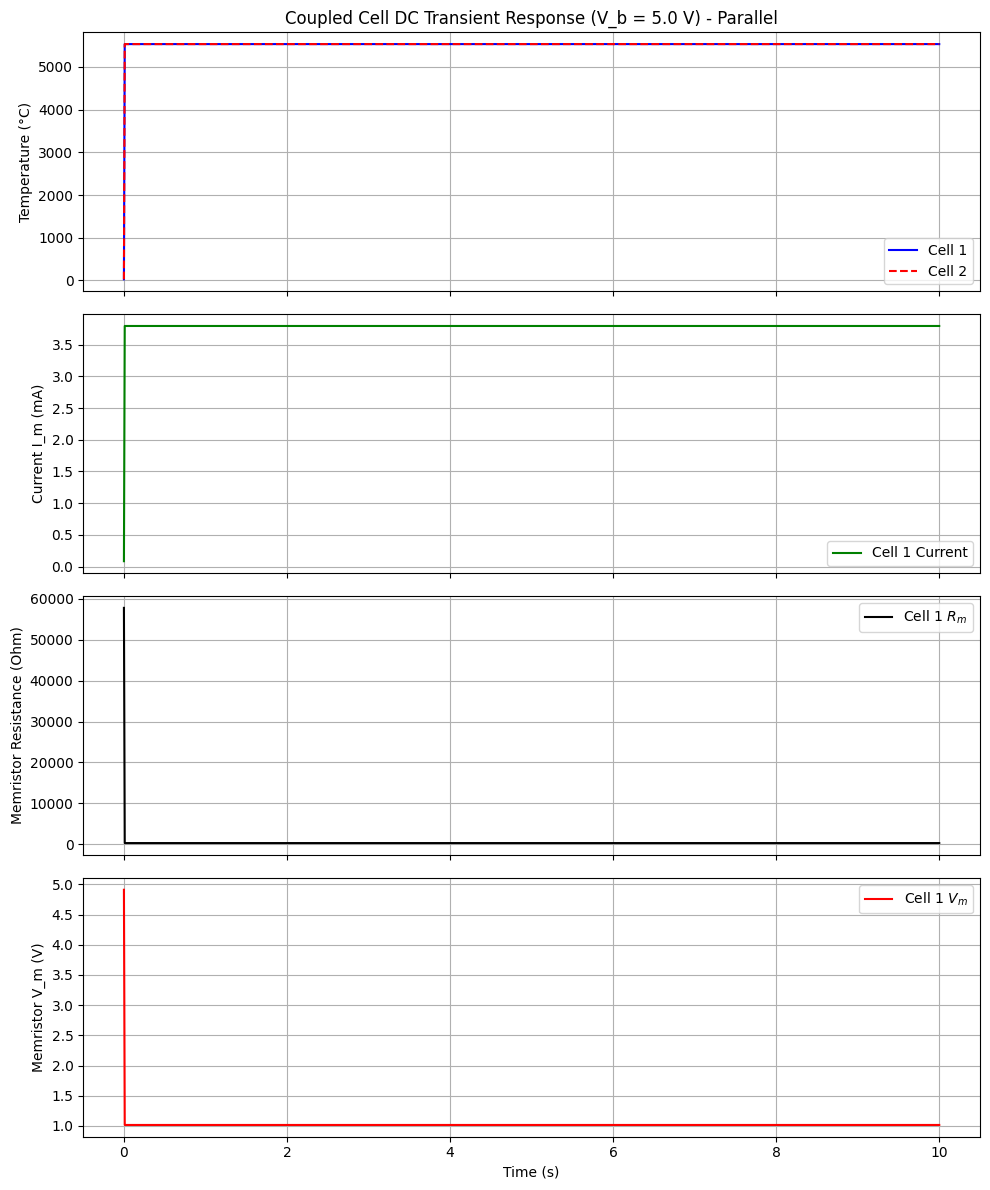

DC Biasing Voltage V_b: 5.00 V
Thermal Time Constant: 1.43e-08 seconds
-----------------------------------
Final Steady State (t=10.0 s):
  Final Temperature T1/T2: 5536.59 °C
  Final Current I_m: 3.7937 mA
  Final Memristor Resistance R_m: 267.98 Ohm


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Device and Biasing Constants ---
# Device Parameters (as specified)
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# Circuit Parameters (Same for both cells)
R_b = 1000.0     # Biasing Resistor (Ohms)
R_s = 50.0       # Series Resistor (Ohms)
V_b_dc = 5.0     # Fixed DC Biasing Voltage (V)

# Simulation Setup
T_max_simulation = 10.0 # Time (s)

# --- 2. Helper Function for Single Cell Calculations (DC Bias) ---
# This is the simplified, correct function for DC analysis.
def calculate_cell_dynamics_dc(T, V_b, g0, g1, R_b, R_s, T_amb, g_th):
    """Calculates Rm, Im, Vm, Vpath, and Pin/Pout for a single cell."""

    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T

    # Path Current I_m
    I_m = V_b / (R_b + R_s + R_m_T)

    # Memristor Voltage V_m
    V_m = I_m * R_m_T

    # Power Input P_in
    P_in = V_m * I_m

    # Power Output P_out
    P_out = g_th * (T - T_amb)

    # Measured Voltage V_path
    V_path = I_m * (R_m_T + R_s)

    return R_m_T, I_m, V_m, P_in, V_path

# --- 3. Define the System of Coupled ODEs (dY/dt) ---
def coupled_memristor_ode(Y, t, g0, g1, C_th, g_th, T_amb, R_b, R_s, V_b):
    """
    Returns the vector of derivatives [dT1/dt, dT2/dt]
    Y is the state vector: Y[0] = T1, Y[1] = T2
    """
    T1, T2 = Y[0], Y[1]

    # Dynamics for Cell 1
    # We pass the constant V_b to the helper function.
    _, _, _, P_in1, _ = calculate_cell_dynamics_dc(T1, V_b, g0, g1, R_b, R_s, T_amb, g_th)
    P_out1 = g_th * (T1 - T_amb)
    dT1dt = (1.0 / C_th) * (P_in1 - P_out1)

    # Dynamics for Cell 2
    _, _, _, P_in2, _ = calculate_cell_dynamics_dc(T2, V_b, g0, g1, R_b, R_s, T_amb, g_th)
    P_out2 = g_th * (T2 - T_amb)
    dT2dt = (1.0 / C_th) * (P_in2 - P_out2)

    return [dT1dt, dT2dt]

# --- 4. Simulation Setup and Solution ---

# Initial conditions: Both cells start at ambient temperature
Y_initial = [T_amb, T_amb]

t = np.linspace(0, T_max_simulation, 1000)

# Solve the coupled ODE system
solution = odeint(
    coupled_memristor_ode,
    Y_initial,
    t,
    args=(g0, g1, C_th, g_th, T_amb, R_b, R_s, V_b_dc)
)

# Extract temperature trajectories
T1_transient = solution[:, 0]
T2_transient = solution[:, 1]

# --- 5. Calculate Output Signals for Plotting ---
# We calculate the outputs based on the solved T1 trajectory
R_m1_transient, I_m1_transient, V_m1_transient, P_in1_transient, V_path1_transient = np.array([
    calculate_cell_dynamics_dc(T, V_b_dc, g0, g1, R_b, R_s, T_amb, g_th) for T in T1_transient
]).T

# --- 6. Plotting the Results ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Temperature vs Time
axes[0].plot(t, T1_transient - 273.15, 'b-', label='Cell 1')
axes[0].plot(t, T2_transient - 273.15, 'r--', label='Cell 2')
axes[0].set_title(f'Coupled Cell DC Transient Response (V_b = {V_b_dc} V) - Parallel')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True)

# Subplot 2: Current I_m vs Time
axes[1].plot(t, I_m1_transient * 1000, 'g-', label='Cell 1 Current')
axes[1].set_ylabel('Current I_m (mA)')
axes[1].legend()
axes[1].grid(True)

# Subplot 3: Memristor Resistance R_m vs Time
# Note: Using '$\Omega$' requires a raw string or escaped backslash if not using LaTeX for the symbol,
# but for simplicity in general Python environments, we will just use Ohm.
axes[2].plot(t, R_m1_transient, 'k-', label='Cell 1 $R_m$')
axes[2].set_ylabel('Memristor Resistance (Ohm)')
axes[2].legend()
axes[2].grid(True)

# Subplot 4: Memristor Voltage V_m vs Time
axes[3].plot(t, V_m1_transient, 'r-', label='Cell 1 $V_m$')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Memristor V_m (V)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

# --- 7. Final Print Statements ---
print(f"DC Biasing Voltage V_b: {V_b_dc:.2f} V")
print(f"Thermal Time Constant: {C_th / g_th:.2e} seconds")
print("-" * 35)
print(f"Final Steady State (t={T_max_simulation:.1f} s):")
print(f"  Final Temperature T1/T2: {T1_transient[-1] - 273.15:.2f} °C")
print(f"  Final Current I_m: {I_m1_transient[-1]*1000:.4f} mA")
print(f"  Final Memristor Resistance R_m: {R_m1_transient[-1]:.2f} Ohm")

<>:105: SyntaxWarning: invalid escape sequence '\m'
<>:105: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1693605056.py:105: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_title(f'R-C Coupled DC Transient Response (C_ext={C_ext*1e6:.1f} $\mu$F, $V_b$={V_b_dc} V)')


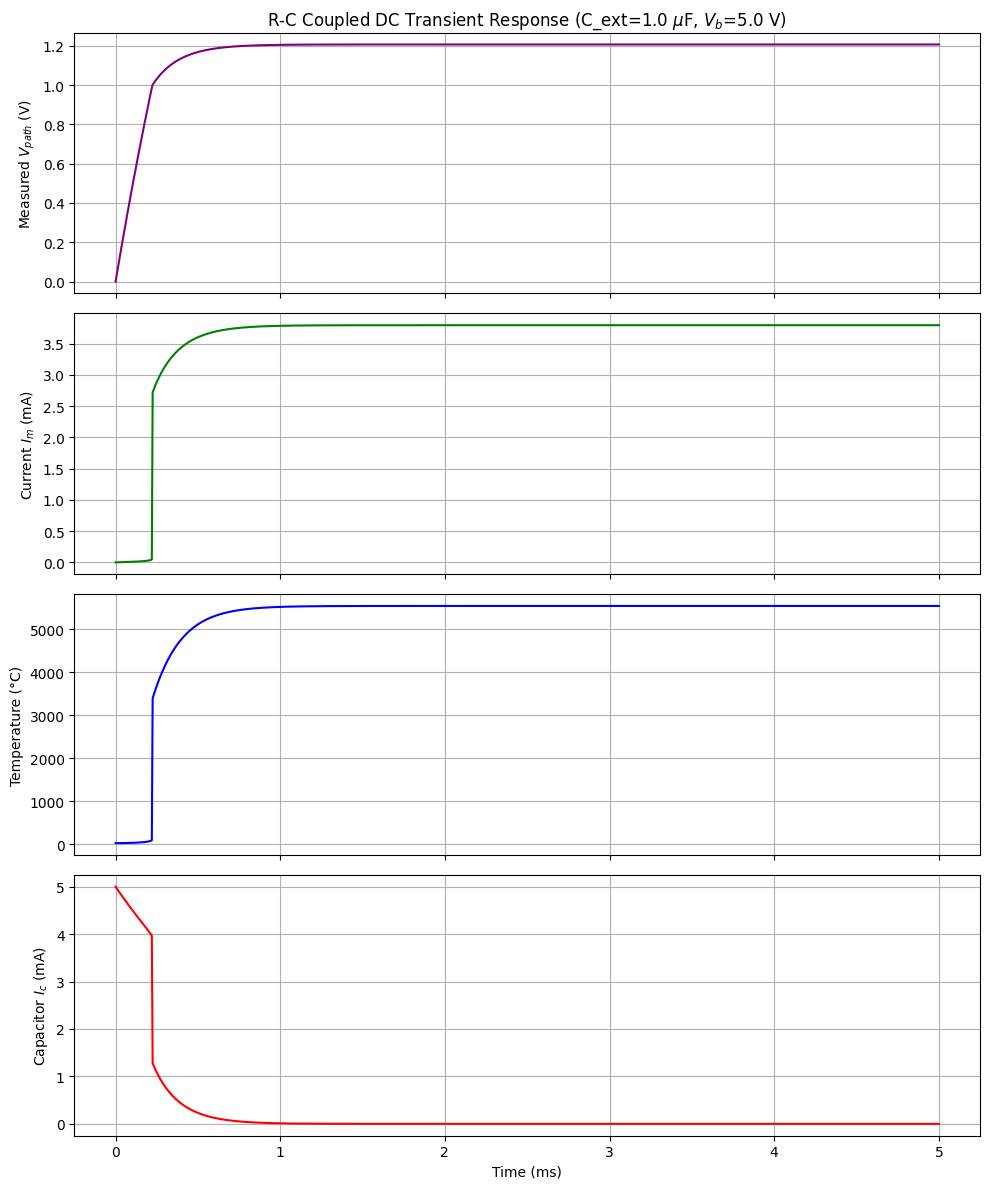

DC Biasing Voltage V_b: 5.00 V
External Capacitor C_ext: 1.0 uF
-----------------------------------
Final Steady State (t=5.0 ms):
  Final Temperature T: 5536.59 °C
  Final Measured V_path: 1.21 V (V_c)
  Final Current I_m: 3.7937 mA


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Device and Circuit Constants ---
# Device Parameters (Thermal)
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# Circuit Parameters
R_b = 1000.0     # Biasing Resistor (Ohms)
R_s = 50.0       # Series Resistor (Ohms)
C_ext = 1e-6     # External Capacitor (F)
V_b_dc = 5.0     # Fixed DC Biasing Voltage (V)

# Simulation Setup
T_max_simulation = 0.005 # Total time (s). Reduced due to the RC circuit (R*C is small).

# --- 2. Define the Coupled System of ODEs (dY/dt) ---
def memristor_coupled_ode(Y, t, g0, g1, C_th, g_th, T_amb, R_b, R_s, C_ext, V_b):
    """
    Returns the vector of derivatives [dT/dt, dVc/dt].
    Y is the state vector: Y[0] = T (Temperature), Y[1] = Vc (Capacitor Voltage/V_path).
    """
    T, Vc = Y[0], Y[1]

    # 2a. Calculate Memristor Resistance R_m(T)
    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T

    # 2b. Electrical Dynamics (dVc/dt)
    R_path = R_s + R_m_T

    # Current from source through R_b
    I_Rb = (V_b - Vc) / R_b

    # Current through the R_s + R_m path
    I_path = Vc / R_path

    # Capacitor Current I_c = I_Rb - I_path
    I_c = I_Rb - I_path

    dVcdt = I_c / C_ext

    # 2c. Thermal Dynamics (dT/dt)
    # The voltage across the memristor V_m is Vc * (R_m / R_path)
    V_m = Vc * (R_m_T / R_path)

    # Power Input P_in = V_m * I_path
    P_in = V_m * I_path

    P_out = g_th * (T - T_amb)

    dTdt = (1.0 / C_th) * (P_in - P_out)

    return [dTdt, dVcdt]

# --- 3. Simulation Setup and Solution ---

# Initial conditions: Device is at ambient temp, capacitor is discharged
Y_initial = [T_amb, 0.0]

t = np.linspace(0, T_max_simulation, 1000)

# Solve the coupled ODE system
solution = odeint(
    memristor_coupled_ode,
    Y_initial,
    t,
    args=(g0, g1, C_th, g_th, T_amb, R_b, R_s, C_ext, V_b_dc)
)

T_transient = solution[:, 0]
V_path_transient = solution[:, 1] # V_path is Vc

# --- 4. Calculate Remaining Output Signals ---
def calculate_output_signals_coupled(T, V_path, V_b, g0, g1, R_b, R_s):
    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T
    R_path = R_s + R_m_T

    # Current I_m is I_path
    I_m = V_path / R_path

    # Memristor Voltage V_m
    V_m = V_path * (R_m_T / R_path)

    # Capacitor Current I_c (for plotting)
    I_c = (V_b - V_path) / R_b - I_m

    return I_m, V_m, R_m_T, I_c

I_m_transient, V_m_transient, R_m_transient, I_c_transient = calculate_output_signals_coupled(
    T_transient, V_path_transient, V_b_dc, g0, g1, R_b, R_s
)

# --- 5. Plotting the Results ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Capacitor Voltage (V_path) vs Time 🟣
axes[0].plot(t * 1000, V_path_transient, color='purple')
axes[0].set_title(f'R-C Coupled DC Transient Response (C_ext={C_ext*1e6:.1f} $\mu$F, $V_b$={V_b_dc} V)')
axes[0].set_ylabel('Measured $V_{path}$ (V)')
axes[0].grid(True)

# Subplot 2: Current I_m vs Time 🟢
axes[1].plot(t * 1000, I_m_transient * 1000, 'g-')
axes[1].set_ylabel('Current $I_m$ (mA)')
axes[1].grid(True)

# Subplot 3: Temperature vs Time 🔵
axes[2].plot(t * 1000, T_transient - 273.15, 'b-')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True)

# Subplot 4: Capacitor Current I_c vs Time 🔴
axes[3].plot(t * 1000, I_c_transient * 1000, 'r-')
axes[3].set_xlabel('Time (ms)')
axes[3].set_ylabel('Capacitor $I_c$ (mA)')
axes[3].grid(True)

plt.tight_layout()
plt.show()

# --- 6. Final Print Statements ---
print(f"DC Biasing Voltage V_b: {V_b_dc:.2f} V")
print(f"External Capacitor C_ext: {C_ext*1e6:.1f} uF")
print("-" * 35)

final_V_path = V_path_transient[-1]
final_I_m = I_m_transient[-1]
final_T = T_transient[-1]

print(f"Final Steady State (t={T_max_simulation*1000:.1f} ms):")
print(f"  Final Temperature T: {final_T - 273.15:.2f} °C")
print(f"  Final Measured V_path: {final_V_path:.2f} V (V_c)")
print(f"  Final Current I_m: {final_I_m*1000:.4f} mA")

<>:99: SyntaxWarning: invalid escape sequence '\m'
<>:99: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3676193145.py:99: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_title(f'Temperature and Current Transient (V_b={V_b_dc} V, $C_{{ext}}$={C_ext*1e6:.1f} $\mu$F)')


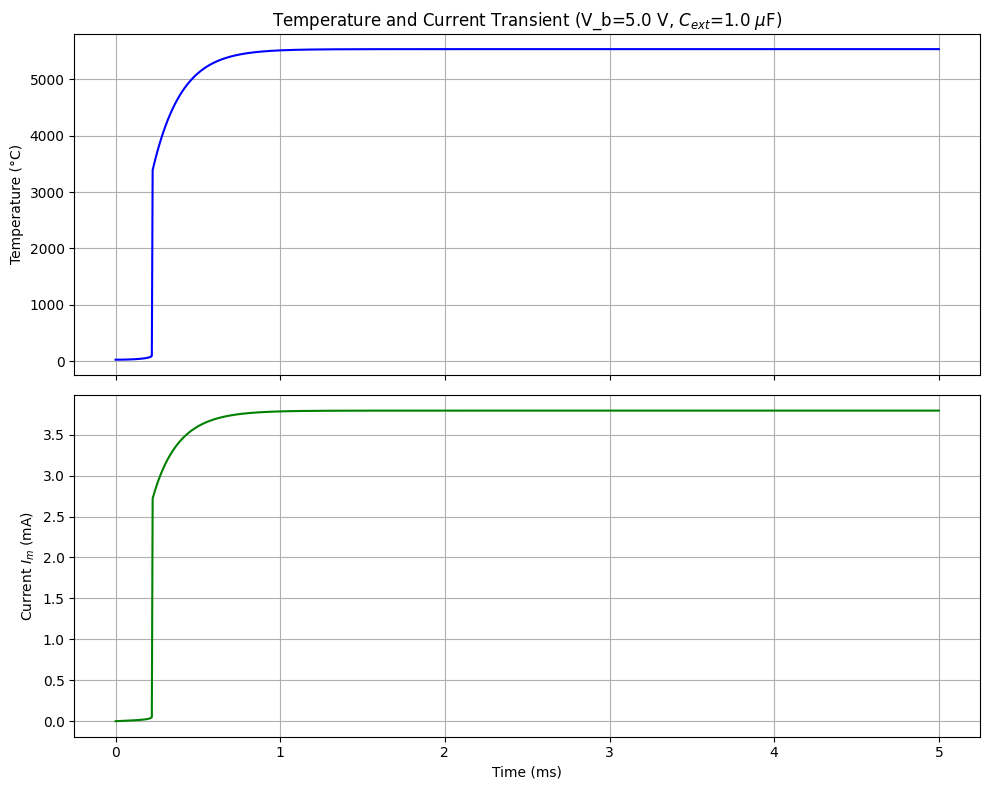

DC Biasing Voltage V_b: 5.00 V
External Capacitor C_ext: 1.0 uF
Thermal Time Constant: 1.43e-08 seconds
-----------------------------------
Final Steady State (t=5.0 ms):
  Final Temperature T: 5536.59 °C
  Final Current I_m: 3.7937 mA


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Device and Circuit Constants ---
# Device Parameters (Thermal)
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# Circuit Parameters
R_b = 1000.0     # Biasing Resistor (Ohms)
R_s = 50.0       # Series Resistor (Ohms)
C_ext = 1e-6     # External Capacitor (F)
V_b_dc = 5.0     # Fixed DC Biasing Voltage (V)

# Simulation Setup
T_max_simulation = 0.005 # Total time (s)

# --- 2. Define the Coupled System of ODEs (dY/dt) ---
def memristor_coupled_ode(Y, t, g0, g1, C_th, g_th, T_amb, R_b, R_s, C_ext, V_b):
    """
    Returns the vector of derivatives [dT/dt, dVc/dt].
    Y is the state vector: Y[0] = T (Temperature), Y[1] = Vc (Capacitor Voltage/V_path).
    """
    T, Vc = Y[0], Y[1]

    # 2a. Calculate Memristor Resistance R_m(T)
    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T

    # 2b. Electrical Dynamics (dVc/dt)
    R_path = R_s + R_m_T

    # Current from source through R_b
    I_Rb = (V_b - Vc) / R_b

    # Current through the R_s + R_m path (I_path = I_m)
    I_path = Vc / R_path

    # Capacitor Current I_c = I_Rb - I_path
    I_c = I_Rb - I_path

    dVcdt = I_c / C_ext

    # 2c. Thermal Dynamics (dT/dt)
    # The voltage across the memristor V_m is Vc * (R_m / R_path)
    V_m = Vc * (R_m_T / R_path)

    # Power Input P_in = V_m * I_path
    P_in = V_m * I_path

    P_out = g_th * (T - T_amb)

    dTdt = (1.0 / C_th) * (P_in - P_out)

    return [dTdt, dVcdt]

# --- 3. Simulation Setup and Solution ---

# Initial conditions: Device is at ambient temp, capacitor is discharged
Y_initial = [T_amb, 0.0]

t = np.linspace(0, T_max_simulation, 1000)

# Solve the coupled ODE system
solution = odeint(
    memristor_coupled_ode,
    Y_initial,
    t,
    args=(g0, g1, C_th, g_th, T_amb, R_b, R_s, C_ext, V_b_dc)
)

T_transient = solution[:, 0]
V_path_transient = solution[:, 1] # V_path is Vc

# --- 4. Calculate Current I_m(t) ---
def calculate_current(T, V_path, R_s, g0, g1):
    """Calculates I_m (I_path) using the solved T and V_path trajectories."""
    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T
    R_path = R_s + R_m_T

    # Current I_m is V_path / R_path
    I_m = V_path / R_path
    return I_m

I_m_transient = calculate_current(
    T_transient, V_path_transient, R_s, g0, g1
)

# --- 5. Plotting the Results (Temperature and Current) ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Subplot 1: Temperature vs Time 🔵
axes[0].plot(t * 1000, T_transient - 273.15, 'b-')
axes[0].set_title(f'Temperature and Current Transient (V_b={V_b_dc} V, $C_{{ext}}$={C_ext*1e6:.1f} $\mu$F)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True)

# Subplot 2: Current I_m vs Time 🟢
axes[1].plot(t * 1000, I_m_transient * 1000, 'g-')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Current $I_m$ (mA)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# --- 6. Final Print Statements ---
final_V_path = V_path_transient[-1]
final_I_m = I_m_transient[-1]
final_T = T_transient[-1]

print(f"DC Biasing Voltage V_b: {V_b_dc:.2f} V")
print(f"External Capacitor C_ext: {C_ext*1e6:.1f} uF")
print(f"Thermal Time Constant: {C_th / g_th:.2e} seconds")
print("-" * 35)

print(f"Final Steady State (t={T_max_simulation*1000:.1f} ms):")
print(f"  Final Temperature T: {final_T - 273.15:.2f} °C")
print(f"  Final Current I_m: {final_I_m*1000:.4f} mA")

<>:109: SyntaxWarning: invalid escape sequence '\O'
<>:109: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-2631203575.py:109: SyntaxWarning: invalid escape sequence '\O'
  axes.set_title(f'Coupled R-C Memristor Cell Voltages Over Time (R_couple={R_couple} $\Omega$)')


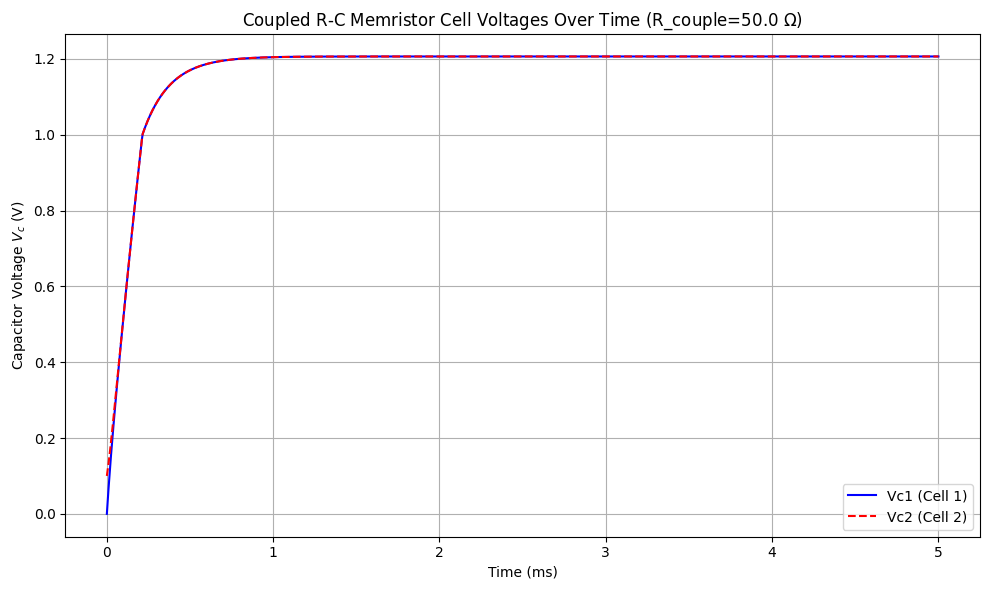

DC Biasing Voltage V_b: 5.00 V
Coupling Resistor R_couple: 50 Ohm (C_couple ignored)
----------------------------------------
Final State (t=5.0 ms):
  Final T1/T2: 5536.59 °C / 5536.59 °C
  Final Vc1: 1.2063 V
  Final Vc2: 1.2063 V


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Device and Circuit Constants ---
# Device Parameters (Thermal - same for both cells)
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# Circuit Parameters (Assumed identical for both cells)
R_b = 1000.0     # Biasing Resistor (Ohms)
R_s = 50.0       # Series Resistor (Ohms)
C_ext = 1e-6     # External Capacitor (F)
V_b_dc = 5.0     # Fixed DC Biasing Voltage (V_b1 and V_b2)

# Coupling Parameters (C_couple ignored for solvability)
R_couple = 50.0  # Coupling Resistor (Ohms)

# Simulation Setup
T_max_simulation = 0.005 # Total time (s)

# --- 2. Helper Function for Cell Dynamics ---
def calculate_cell_dynamics(T, V_c, R_s, g0, g1):
    """Calculates Rm, Im, and Vm for a single cell given T and Vc."""
    G_T = g0 * np.exp(-g1 / T)
    R_m_T = 1.0 / G_T
    R_path = R_s + R_m_T

    # Current I_m is I_path
    I_m = V_c / R_path

    # Memristor Voltage V_m
    V_m = V_c * (R_m_T / R_path)

    return R_m_T, I_m, V_m

# --- 3. Define the System of Coupled ODEs (dY/dt) ---
def coupled_rc_memristor_ode(Y, t, g0, g1, C_th, g_th, T_amb, R_b, R_s, C_ext, V_b, R_couple):
    """
    Returns the vector of derivatives [dT1/dt, dVc1/dt, dT2/dt, dVc2/dt].
    Y is the state vector: Y[0]=T1, Y[1]=Vc1, Y[2]=T2, Y[3]=Vc2
    """
    T1, Vc1, T2, Vc2 = Y[0], Y[1], Y[2], Y[3]

    # --- Cell 1 Calculations ---
    R_m1, I_m1, V_m1 = calculate_cell_dynamics(T1, Vc1, R_s, g0, g1)

    # --- Cell 2 Calculations ---
    R_m2, I_m2, V_m2 = calculate_cell_dynamics(T2, Vc2, R_s, g0, g1)

    # --- ODEs ---

    # 1. dT1/dt (Thermal 1)
    P_in1 = V_m1 * I_m1
    dT1dt = (1.0 / C_th) * (P_in1 - g_th * (T1 - T_amb))

    # 2. dVc1/dt (Electrical 1 - KCL at Vc1)
    I_Rb1 = (V_b - Vc1) / R_b
    I_path1 = I_m1
    I_R_couple = (Vc1 - Vc2) / R_couple

    I_c1 = I_Rb1 - I_path1 - I_R_couple
    dVc1dt = I_c1 / C_ext

    # 3. dT2/dt (Thermal 2)
    P_in2 = V_m2 * I_m2
    dT2dt = (1.0 / C_th) * (P_in2 - g_th * (T2 - T_amb))

    # 4. dVc2/dt (Electrical 2 - KCL at Vc2)
    I_Rb2 = (V_b - Vc2) / R_b
    I_path2 = I_m2
    # Current from coupling is in the opposite direction for cell 2
    I_R_couple_rev = (Vc2 - Vc1) / R_couple

    I_c2 = I_Rb2 - I_path2 - I_R_couple_rev
    dVc2dt = I_c2 / C_ext

    return [dT1dt, dVc1dt, dT2dt, dVc2dt]

# --- 4. Simulation Setup and Solution ---

# Introduce a small initial condition mismatch to see coupling effects
# Cell 1 starts at Vc=0, Cell 2 starts slightly higher (e.g., 0.1V)
Y_initial = [T_amb, 0.0, T_amb, 0.1]

t = np.linspace(0, T_max_simulation, 1000)

# Solve the coupled 4-ODE system
solution = odeint(
    coupled_rc_memristor_ode,
    Y_initial,
    t,
    args=(g0, g1, C_th, g_th, T_amb, R_b, R_s, C_ext, V_b_dc, R_couple)
)

T1_transient = solution[:, 0]
V_path1_transient = solution[:, 1]
T2_transient = solution[:, 2]
V_path2_transient = solution[:, 3]

# --- 5. Plotting the Evolution of Vc1 and Vc2 ---
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.plot(t * 1000, V_path1_transient, 'b-', label='Vc1 (Cell 1)')
axes.plot(t * 1000, V_path2_transient, 'r--', label='Vc2 (Cell 2)')
axes.set_title(f'Coupled R-C Memristor Cell Voltages Over Time (R_couple={R_couple} $\Omega$)')
axes.set_xlabel('Time (ms)')
axes.set_ylabel('Capacitor Voltage $V_c$ (V)')
axes.legend()
axes.grid(True)

plt.tight_layout()
plt.show()

# --- 6. Final Print Statements (Including Vc evolution) ---
print(f"DC Biasing Voltage V_b: {V_b_dc:.2f} V")
print(f"Coupling Resistor R_couple: {R_couple:.0f} Ohm (C_couple ignored)")
print("-" * 40)

# Calculate final state for print
final_T1 = T1_transient[-1]
final_Vc1 = V_path1_transient[-1]
final_Vc2 = V_path2_transient[-1]

print(f"Final State (t={T_max_simulation*1000:.1f} ms):")
print(f"  Final T1/T2: {final_T1 - 273.15:.2f} °C / {T2_transient[-1] - 273.15:.2f} °C")
print(f"  Final Vc1: {final_Vc1:.4f} V")
print(f"  Final Vc2: {final_Vc2:.4f} V")

<>:108: SyntaxWarning: invalid escape sequence '\O'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\O'
<>:109: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3700177314.py:108: SyntaxWarning: invalid escape sequence '\O'
  plt.title(f'Coupled VO2 Oscillators ($R_{{couple}}$={R_couple/1e3:.0f}k$\Omega$, $C_{{couple}}$={C_couple/1e-12:.0f}pF)')
/tmp/ipython-input-3700177314.py:109: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Time ($\mu s$)')


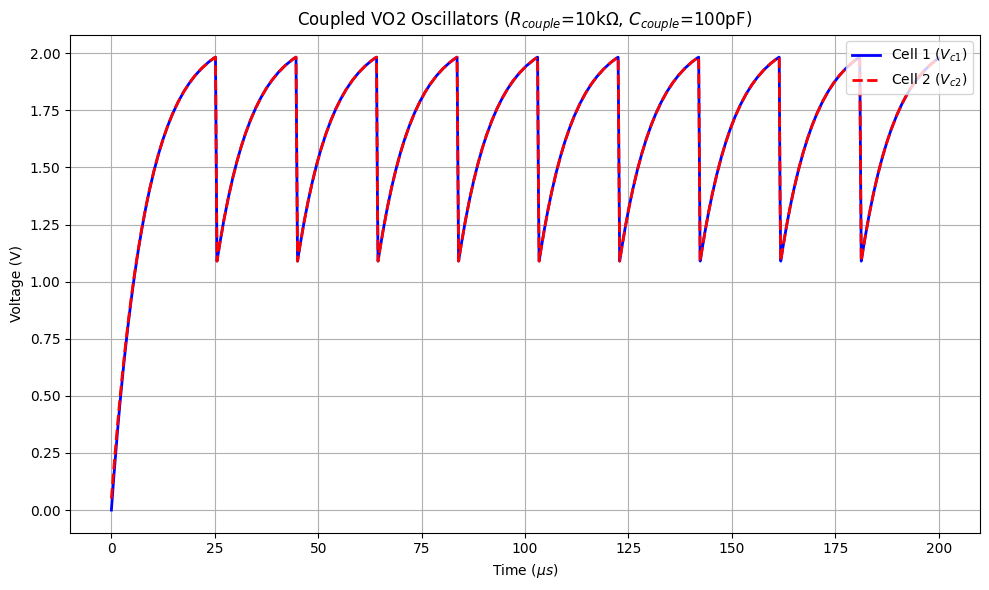

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 1. System Parameters (Based on Uploaded Paper) ---
# VO2 Device Parameters
R_ins = 100.2e3  # Resistance in Insulator State (Ohms)
R_met = 0.99e3   # Resistance in Metallic State (Ohms)
V_L = 1.0        # Low Threshold (V)
V_H = 1.99       # High Threshold (V)
alpha = 200.0    # Hysteresis steepness parameter
tau_0 = 10e-9    # Internal state time constant (10 ns)

# Circuit Parameters (User Sketch)
V_b = 2.5        # Bias Voltage (V)
R_b = 20e3       # Bias Resistor (Ohms) - Sets the Load Line
R_s = 100.0      # Small Series Resistor with VO2 (Ohms)
C_ext = 500e-12  # External Capacitor (500 pF)

# Coupling Network Parameters
R_couple = 10e3    # Coupling Resistor (20 kOhm)
C_couple = 100e-12 # Coupling Capacitor (100 pF)

# --- 2. Maffezzoni VO2 Model Functions ---
def get_R_mem(u):
    """
    Returns Memristor Resistance based on Metallic State fraction 'u'.
    u=0 (Insulator) -> R_ins
    u=1 (Metal)     -> R_met
    """
    # Conductance is linear combination of states
    G = (1 - u) / R_ins + u / R_met
    return 1.0 / G

def hysteresis_target(V_mem, u_current):
    """
    Calculates the target state (0 or 1) based on Voltage and Hysteresis.
    Implements the tanh function from Maffezzoni et al.
    """
    # We use (1-u) as a proxy for the hysteresis state V0 to smooth the transition
    # If u ~ 0 (Insulator), Threshold is V_H
    # If u ~ 1 (Metal), Threshold is V_L
    V0_est = 1.0 - u_current
    arg = 2 * alpha * ((V_H - V_L) * V0_est + V_L - V_mem)

    # Sigmoid transition function (0 to 1)
    V0_target = 0.5 * (1 + np.tanh(arg))

    # Target 'u' is 1 - V0 (Since V0=1 is Insulator in paper, u=1 is Metal here)
    return 1.0 - V0_target

# --- 3. Coupled Circuit ODEs ---
def circuit_odes(t, y):
    # State Vector: [Vc1, Vc2, u1, u2]
    # Vc1, Vc2: Voltages across the C_ext capacitors
    # u1, u2:   Internal metallic state of VO2 devices
    Vc1, Vc2, u1, u2 = y

    # -- A. Update VO2 States --
    R_mem1 = get_R_mem(u1)
    R_mem2 = get_R_mem(u2)

    # Voltage across the VO2 device (Voltage Divider with R_s)
    V_mem1 = Vc1 * R_mem1 / (R_s + R_mem1)
    V_mem2 = Vc2 * R_mem2 / (R_s + R_mem2)

    # Dynamics of internal states u (Relaxation to Hysteresis Target)
    u1_target = hysteresis_target(V_mem1, u1)
    du1_dt = (u1_target - u1) / tau_0

    u2_target = hysteresis_target(V_mem2, u2)
    du2_dt = (u2_target - u2) / tau_0

    # -- B. Circuit KCL Equations (Coupled) --
    # Currents entering/leaving the nodes
    I_src1 = (V_b - Vc1) / R_b
    I_branch1 = Vc1 / (R_s + R_mem1)
    I_res_couple = (Vc1 - Vc2) / R_couple

    I_src2 = (V_b - Vc2) / R_b
    I_branch2 = Vc2 / (R_s + R_mem2)

    # KCL Equations rearranged for dVc1/dt and dVc2/dt
    # Matrix form: [C1 -Cc] * [dV1] = [I_net1]
    #              [-Cc C2]   [dV2]   [I_net2]
    RHS1 = I_src1 - I_branch1 - I_res_couple
    RHS2 = I_src2 - I_branch2 + I_res_couple

    C_sum = C_ext + C_couple
    det = C_sum * C_sum - C_couple * C_couple

    dVc1_dt = (C_sum * RHS1 + C_couple * RHS2) / det
    dVc2_dt = (C_couple * RHS1 + C_sum * RHS2) / det

    return [dVc1_dt, dVc2_dt, du1_dt, du2_dt]

# --- 4. Simulation ---
t_span = (0, 200e-6) # Simulate for 50 microseconds
# Start with slight mismatch to observe synchronization dynamics
y0 = [0.0, 0.05, 0.0, 0.0]

sol = solve_ivp(circuit_odes, t_span, y0, method='Radau', rtol=1e-6, atol=1e-9)

# --- 5. Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(sol.t * 1e6, sol.y[0], 'b-', label='Cell 1 ($V_{c1}$)', linewidth=2)
plt.plot(sol.t * 1e6, sol.y[1], 'r--', label='Cell 2 ($V_{c2}$)', linewidth=2)
plt.title(f'Coupled VO2 Oscillators ($R_{{couple}}$={R_couple/1e3:.0f}k$\Omega$, $C_{{couple}}$={C_couple/1e-12:.0f}pF)')
plt.xlabel('Time ($\mu s$)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('coupled_oscillations.png')
plt.show()

<>:114: SyntaxWarning: invalid escape sequence '\m'
<>:114: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1199932886.py:114: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel('Time ($\mu s$)', fontsize=12)


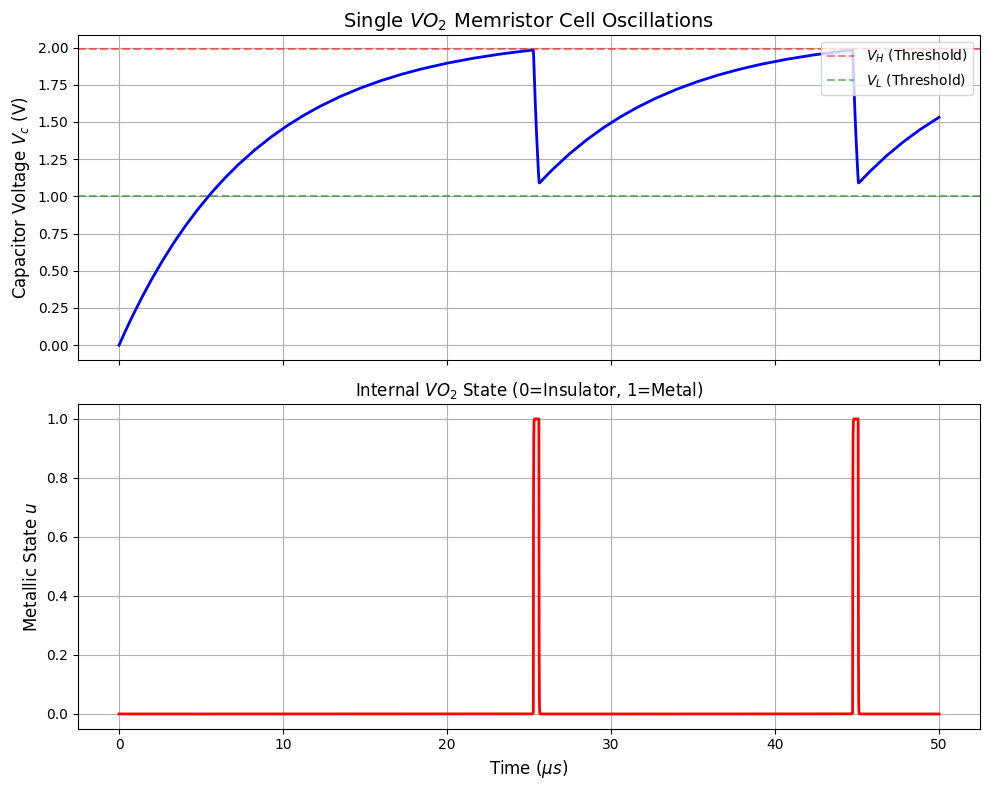

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 1. System Parameters ---
# Values taken from Table 1 of the provided paper [cite: 100]
R_ins = 100.2e3  # VO2 Resistance in Insulating state (Ohms)
R_met = 0.99e3   # VO2 Resistance in Metallic state (Ohms)
V_L = 1.0        # Low voltage threshold for MIT transition (V)
V_H = 1.99       # High voltage threshold for IMT transition (V)
alpha = 200.0    # Curve fitting parameter for hysteresis steepness
tau_0 = 10e-9    # Internal state transition time constant (10 ns)

# Circuit Parameters (Based on user sketch and paper context)
V_b = 2.5        # Bias Voltage (V) [cite: 100]
R_b = 20e3       # Bias Resistor (Ohms) - Corresponds to Rs in paper Fig 2B
R_s = 100.0      # Series Resistor in the VO2 branch (Ohms)
C_ext = 500e-12  # External Capacitor (500 pF) [cite: 100]

# --- 2. VO2 Model Functions ---
def get_R_mem(u):
    """
    Calculates Memristor Resistance based on the metallic state fraction 'u'.
    u = 0 -> Insulator state
    u = 1 -> Metallic state
    Equation derived from the conductance relationship G = (1-u)/Rins + u/Rmet.
    """
    # G = (1 - u) / R_ins + u / R_met

    return 1.0 / G

def hysteresis_target(V_mem, u_current):
    """
    Calculates the target state for the VO2 device dynamics.
    Implements the hyperbolic tangent hysteresis function described in the paper[cite: 144].
    """
    # V0 represents the "Insulator" probability.
    # We use (1-u) as a proxy for V0 to determine the current threshold.
    V0_est = 1.0 - u_current

    # The argument for the tanh function defines the switching thresholds:
    # If V_mem > V_H (and u~0), the argument becomes negative, driving u to 1.
    # If V_mem < V_L (and u~1), the argument becomes positive, driving u to 0.
    arg = 2 * alpha * ((V_H - V_L) * V0_est + V_L - V_mem)

    # Calculate target V0 (Insulator state target)
    V0_target = 0.5 * (1 + np.tanh(arg))

    # Return target 'u' (Metallic state target), which is 1 - V0
    return 1.0 - V0_target

# --- 3. Circuit ODEs ---
def single_cell_ode(t, y):
    """
    Defines the differential equations for the single cell.
    y[0] = Vc (Voltage across Capacitor / Parallel Branch)
    y[1] = u  (Internal Metallic State of VO2)
    """
    Vc, u = y

    # --- Component States ---
    R_mem = get_R_mem(u)

    # Important: The voltage triggering the VO2 is the voltage across the
    # device itself, not the total branch voltage Vc.
    # We use a voltage divider rule with Rs.
    V_mem = Vc * (R_mem / (R_s + R_mem))

    # --- 1. Electrical Dynamics (Kirchhoff's Current Law) ---
    # Current entering from source: I_in = (V_b - Vc) / R_b
    # Current leaving through VO2 branch: I_out = Vc / (R_s + R_mem)
    # Capacitor current: I_cap = C_ext * dVc/dt = I_in - I_out

    I_in = (V_b - Vc) / R_b
    I_out = Vc / (R_s + R_mem)

    dVc_dt = (I_in - I_out) / C_ext

    # --- 2. Internal VO2 Dynamics ---
    # The state 'u' relaxes towards its target value with time constant tau_0.
    u_tgt = hysteresis_target(V_mem, u)
    du_dt = (u_tgt - u) / tau_0

    return [dVc_dt, du_dt]

# --- 4. Simulation ---
# Simulate for 50 microseconds to see multiple cycles
t_span = (0, 50e-6)

# Initial Conditions: Capacitor discharged (0V), VO2 in Insulating state (u=0)
y0 = [0.0, 0.0]

# Solve using a stiff solver (Radau) due to the fast switching of the VO2
solution = solve_ivp(single_cell_ode, t_span, y0, method='Radau', rtol=1e-6, atol=1e-9)

# --- 5. Plotting ---
t_plot = solution.t * 1e6 # Convert to microseconds
Vc_plot = solution.y[0]
u_plot = solution.y[1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Vc (Capacitor Voltage)
ax1.plot(t_plot, Vc_plot, 'b-', linewidth=2)
ax1.set_ylabel('Capacitor Voltage $V_c$ (V)', fontsize=12)
ax1.set_title('Single $VO_2$ Memristor Cell Oscillations', fontsize=14)
ax1.grid(True)
ax1.axhline(V_H, color='r', linestyle='--', alpha=0.5, label='$V_H$ (Threshold)')
ax1.axhline(V_L, color='g', linestyle='--', alpha=0.5, label='$V_L$ (Threshold)')
ax1.legend(loc='upper right')

# Plot u (Metallic State)
ax2.plot(t_plot, u_plot, 'r-', linewidth=2)
ax2.set_ylabel('Metallic State $u$', fontsize=12)
ax2.set_xlabel('Time ($\mu s$)', fontsize=12)
ax2.set_title('Internal $VO_2$ State (0=Insulator, 1=Metal)', fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()